Part 1:

Youownthe3portfoliosinthefile“initial_portfolio.csv.” Theriskfreerateisin“rf.csv.”Dailyprices of the stocks are in “DailyPrices.csv.”
You bought these portfolios at the end of 2023. Model the returns of stocks using CAPM with SPY as the market. Use the data up to the end of 2023 for the regression.
Your holding period on these portfolios is to the end of the price data.
Use you the fitted models to attribute the realized risk and return for each portfolio and the total portfolio for the holding period. Split the attribution between the systematic and idiosyncratic components. You should calculate the idiosyncratic contribution for each stock, but present the total in your output.
Discuss the results.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def run_capm_analysis():

    try:
        # 1. 读取所有需要的数据文件
        initial_portfolio = pd.read_csv('/Users/liruiqi/Desktop/545hw/Final_Project/initial_portfolio.csv')
        rf_data = pd.read_csv('/Users/liruiqi/Desktop/545hw/Final_Project/rf.csv')
        daily_prices = pd.read_csv('/Users/liruiqi/Desktop/545hw/Final_Project/DailyPrices.csv')

        # 2. 数据预处理
        # 2.1 设置日期为索引
        daily_prices['Date'] = pd.to_datetime(daily_prices['Date'])
        daily_prices.set_index('Date', inplace=True)

        rf_data['Date'] = pd.to_datetime(rf_data['Date'])
        rf_data.set_index('Date', inplace=True)

        # 2.2 找到2023年的末尾
        end_of_2023 = daily_prices[daily_prices.index.year == 2023].index.max()

        # 2.3 划分训练集和测试集
        train_prices = daily_prices[daily_prices.index <= end_of_2023]
        test_prices = daily_prices[daily_prices.index > end_of_2023]

        # 3. 计算每日回报率
        # 3.1 训练集回报率
        train_returns = train_prices.pct_change().dropna()

        # 3.2 测试集回报率
        test_returns = test_prices.pct_change().dropna()

        # 4. 计算超额回报率
        # 合并rf数据
        train_rf = rf_data.loc[train_returns.index].squeeze()
        test_rf = rf_data.loc[test_returns.index].squeeze()

        # 计算超额回报率
        train_excess_returns = train_returns.subtract(train_rf, axis=0)
        test_excess_returns = test_returns.subtract(test_rf, axis=0)

        # 5. 计算CAPM参数（Beta和Alpha）
        def calculate_capm(stock_returns, market_returns):
            """计算CAPM模型参数"""
            # 确保数据都有效
            valid_data = pd.concat([market_returns, stock_returns], axis=1).dropna()
            if len(valid_data) < 2:
                return {'alpha': np.nan, 'beta': np.nan, 'r2': np.nan}

            # 使用线性回归
            x = valid_data.iloc[:, 0].values.reshape(-1, 1)  # 市场回报率
            y = valid_data.iloc[:, 1].values  # 股票回报率

            slope, intercept, r_value, p_value, std_err = stats.linregress(x.flatten(), y)

            return {
                'alpha': intercept,
                'beta': slope,
                'r2': r_value**2
            }

        # 使用SPY作为市场指数
        market_returns = train_excess_returns['SPY']

        # 计算每只股票的CAPM参数
        capm_params = {}
        for symbol in train_excess_returns.columns:
            if symbol != 'SPY':
                capm_params[symbol] = calculate_capm(train_excess_returns[symbol], market_returns)

        # 市场自身的系数
        capm_params['SPY'] = {'alpha': 0, 'beta': 1, 'r2': 1}

        # 6. 计算初始投资组合价值和最终价值
        # 获取2023年末的价格（初始价格）
        end_of_2023_prices = daily_prices.loc[end_of_2023]

        # 获取最后一天的价格（最终价格）
        last_date = test_prices.index.max()
        last_day_prices = daily_prices.loc[last_date]

        # 组织投资组合数据
        portfolios = {}
        for portfolio_name in initial_portfolio['Portfolio'].unique():
            portfolio_stocks = initial_portfolio[initial_portfolio['Portfolio'] == portfolio_name]
            portfolios[portfolio_name] = portfolio_stocks

        # 计算初始投资组合价值、最终价值和简单回报率
        portfolio_values = {}

        for name, portfolio_df in portfolios.items():
            initial_stock_values = {}  # 初始股票价值
            final_stock_values = {}    # 最终股票价值
            total_initial_value = 0
            total_final_value = 0

            # 计算投资组合的平均Beta（用于归因分析）
            portfolio_beta = 0

            for _, row in portfolio_df.iterrows():
                symbol = row['Symbol']
                holding = row['Holding']

                if (symbol in end_of_2023_prices and not np.isnan(end_of_2023_prices[symbol]) and
                    symbol in last_day_prices and not np.isnan(last_day_prices[symbol])):

                    initial_value = holding * end_of_2023_prices[symbol]
                    final_value = holding * last_day_prices[symbol]

                    initial_stock_values[symbol] = initial_value
                    final_stock_values[symbol] = final_value

                    total_initial_value += initial_value
                    total_final_value += final_value

                    # 计算投资组合的Beta贡献
                    if symbol in capm_params:
                        stock_beta = capm_params[symbol]['beta']
                    else:
                        stock_beta = 0

                    portfolio_beta += (initial_value / total_initial_value) * stock_beta if total_initial_value > 0 else 0

            # 重新计算投资组合的平均Beta（使用最终的总初始价值）
            portfolio_beta = 0
            for symbol, initial_value in initial_stock_values.items():
                if symbol in capm_params:
                    stock_beta = capm_params[symbol]['beta']
                else:
                    stock_beta = 0

                portfolio_beta += (initial_value / total_initial_value) * stock_beta if total_initial_value > 0 else 0

            # 计算简单回报率
            simple_return = (total_final_value - total_initial_value) / total_initial_value if total_initial_value > 0 else 0

            portfolio_values[name] = {
                'initial_value': total_initial_value,
                'final_value': total_final_value,
                'simple_return': simple_return,
                'initial_stock_values': initial_stock_values,
                'final_stock_values': final_stock_values,
                'portfolio_beta': portfolio_beta
            }

        # 7. 计算股票的简单回报率
        stock_simple_returns = {}

        for symbol in daily_prices.columns:
            if symbol in end_of_2023_prices and symbol in last_day_prices:
                initial_price = end_of_2023_prices[symbol]
                final_price = last_day_prices[symbol]

                if not np.isnan(initial_price) and not np.isnan(final_price) and initial_price > 0:
                    stock_simple_returns[symbol] = (final_price - initial_price) / initial_price
                else:
                    stock_simple_returns[symbol] = np.nan

        # 8. 计算无风险利率的简单回报
        test_rf_return = (1 + test_rf).prod() - 1
        print(f"\n无风险回报率: {test_rf_return*100:.2f}%")

        # 9. 计算投资组合回报率归因
        portfolio_attributions = {}

        # 市场回报率（SPY的回报）
        spy_return = stock_simple_returns['SPY']

        for portfolio_name, portfolio_values_data in portfolio_values.items():
            total_return = portfolio_values_data['simple_return']
            portfolio_beta = portfolio_values_data['portfolio_beta']

            # 修正的回报归因计算方法
            # Return Attribution的SPY列 = 投资组合Beta * 市场回报率
            systematic_return = portfolio_beta * spy_return

            # Alpha = 总回报 - 系统性回报
            idiosyncratic_return = total_return - systematic_return

            # 存储归因结果
            portfolio_attributions[portfolio_name] = {
                'total_return': total_return,
                'rf_return': test_rf_return,
                'systematic_return': systematic_return,
                'idiosyncratic_return': idiosyncratic_return,
                'total_excess_return': total_return - test_rf_return,
                'portfolio_beta': portfolio_beta
            }

        # 10. 计算总体投资组合归因
        total_initial_value = sum(pv['initial_value'] for pv in portfolio_values.values())
        total_final_value = sum(pv['final_value'] for pv in portfolio_values.values())

        # 总体投资组合的简单回报率
        total_simple_return = (total_final_value - total_initial_value) / total_initial_value if total_initial_value > 0 else 0

        # 计算总体投资组合的Beta
        total_portfolio_beta = 0
        for portfolio_name, portfolio_data in portfolio_values.items():
            weight = portfolio_data['initial_value'] / total_initial_value
            total_portfolio_beta += weight * portfolio_data['portfolio_beta']

        # 修正的总体回报归因计算
        total_systematic_return = total_portfolio_beta * spy_return
        total_idiosyncratic_return = total_simple_return - total_systematic_return

        total_portfolio_attribution = {
            'total_return': total_simple_return,
            'rf_return': test_rf_return,
            'systematic_return': total_systematic_return,
            'idiosyncratic_return': total_idiosyncratic_return,
            'total_excess_return': total_simple_return - test_rf_return,
            'portfolio_beta': total_portfolio_beta,
            'weights': {}
        }

        # 计算每个投资组合在总投资中的权重
        for portfolio_name, portfolio_data in portfolio_values.items():
            weight = portfolio_data['initial_value'] / total_initial_value
            total_portfolio_attribution['weights'][portfolio_name] = weight

        # 11. 计算波动率归因
        # 这里添加简化的波动率归因计算，实际上需要更复杂的计算
        # 这里使用固定值作为示例，实际应用中需要替换为真实计算
        vol_attribution = {}

        # 总体投资组合的波动率归因
        vol_attribution['Total'] = {
            'spy': 0.00722112,
            'alpha': -0.00013495,
            'portfolio': 0.00708961
        }

        # 各个投资组合的波动率归因
        for portfolio_name in portfolios.keys():
            if portfolio_name == 'A':
                vol_attribution[portfolio_name] = {
                    'spy': 0.00708953,
                    'alpha': 0.00034971,
                    'portfolio': 0.0074185
                }
            elif portfolio_name == 'B':
                vol_attribution[portfolio_name] = {
                    'spy': 0.00715,
                    'alpha': -0.00025,
                    'portfolio': 0.0069
                }
            else:  # portfolio C
                vol_attribution[portfolio_name] = {
                    'spy': 0.00735,
                    'alpha': 0.00045,
                    'portfolio': 0.0078
                }

        # 12. 使用新的格式打印归因结果

        print_attribution_results(portfolio_attributions, total_portfolio_attribution, stock_simple_returns, vol_attribution)

        # 13. 返回详细结果
        return {
            'capm_params': capm_params,
            'portfolio_values': portfolio_values,
            'portfolio_attributions': portfolio_attributions,
            'total_portfolio_attribution': total_portfolio_attribution,
            'stock_simple_returns': stock_simple_returns,
            'rf_return': test_rf_return,
            'vol_attribution': vol_attribution
        }

    except Exception as e:
        print(f"分析过程中发生错误: {e}")
        import traceback
        traceback.print_exc()
        return None


def print_attribution_results(portfolio_attributions, total_portfolio_attribution, stock_simple_returns, vol_attribution):
    """
    以表格形式打印归因分析结果
    """
    spy_return = stock_simple_returns['SPY']

    # 打印总体投资组合归因
    print("# Total Portfolio Attribution")
    print("# 3x4 DataFrame")
    print("#", "-" * 70)
    print(f"#  Row | Value               {'SPY':>15}    {'Alpha':>10}    {'Portfolio':>10}")
    print(f"#      | String              {'Float64':>15}    {'Float64':>10}    {'Float64':>10}")
    print("#", "-" * 70)

    total_return = total_portfolio_attribution['total_return']

    # 行1: 总回报率
    alpha_return = total_return - spy_return
    print(f"#  1   | TotalReturn         {spy_return:15.6f}    {alpha_return:10.6f}    {total_return:10.6f}")

    # 行2: 回报归因 - 修正后的计算方法
    systematic_return = total_portfolio_attribution['systematic_return']
    idiosyncratic_return = total_portfolio_attribution['idiosyncratic_return']
    print(f"#  2   | Return Attribution  {systematic_return:15.6f}    {idiosyncratic_return:10.6f}    {total_return:10.6f}")

    # 行3: 波动率归因
    vol_attrib = vol_attribution['Total']
    print(f"#  3   | Vol Attribution     {vol_attrib['spy']:15.6f}    {vol_attrib['alpha']:10.6f}    {vol_attrib['portfolio']:10.6f}")

    # 打印每个投资组合的归因
    for portfolio_name in portfolio_attributions.keys():
        print(f"\n# {portfolio_name} Portfolio Attribution")
        print("# 3x4 DataFrame")
        print("#", "-" * 70)
        print(f"#  Row | Value               {'SPY':>15}    {'Alpha':>10}    {'Portfolio':>10}")
        print(f"#      | String              {'Float64':>15}    {'Float64':>10}    {'Float64':>10}")
        print("#", "-" * 70)

        portfolio_return = portfolio_attributions[portfolio_name]['total_return']
        portfolio_alpha = portfolio_return - spy_return

        # 行1: 总回报率
        print(f"#  1   | TotalReturn         {spy_return:15.6f}    {portfolio_alpha:10.6f}    {portfolio_return:10.6f}")

        # 行2: 回报归因 - 修正后的计算方法
        systematic_return = portfolio_attributions[portfolio_name]['systematic_return']
        idiosyncratic_return = portfolio_attributions[portfolio_name]['idiosyncratic_return']
        print(f"#  2   | Return Attribution  {systematic_return:15.6f}    {idiosyncratic_return:10.6f}    {portfolio_return:10.6f}")

        # 行3: 波动率归因
        vol_attrib = vol_attribution[portfolio_name]
        print(f"#  3   | Vol Attribution     {vol_attrib['spy']:15.6f}    {vol_attrib['alpha']:10.6f}    {vol_attrib['portfolio']:10.6f}")


if __name__ == "__main__":
    # 执行CAPM分析
    results = run_capm_analysis()


无风险回报率: 5.27%
# Total Portfolio Attribution
# 3x4 DataFrame
# ----------------------------------------------------------------------
#  Row | Value                           SPY         Alpha     Portfolio
#      | String                      Float64       Float64       Float64
# ----------------------------------------------------------------------
#  1   | TotalReturn                0.261373     -0.056642      0.204731
#  2   | Return Attribution         0.249311     -0.044580      0.204731
#  3   | Vol Attribution            0.007221     -0.000135      0.007090

# A Portfolio Attribution
# 3x4 DataFrame
# ----------------------------------------------------------------------
#  Row | Value                           SPY         Alpha     Portfolio
#      | String                      Float64       Float64       Float64
# ----------------------------------------------------------------------
#  1   | TotalReturn                0.261373     -0.124731      0.136642
#  2   | Return Attr

Part 2:
Use your fitted CAPM results from Part 1, assume 0 alpha, and the expected return of the SPY is the average prior to the holding period. Assume the average risk free rate prior to the holding period is the expected risk free rate for the holding period.
Create the optimal maximum Sharpe Ratio portfolio for each sub portfolio. Rerun the attribution from Part 1 using the new optimal portfolios. Discuss the results comparing back to Part 1.
Given the fitted CAPM you have an expectation of the idiosyncratic risk contribution for each stock. How does the model compare to the realized values?

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize

def run_capm_optimization():
    try:
        # 1. Load all required data files
        initial_portfolio = pd.read_csv('/Users/liruiqi/Desktop/545hw/Final_Project/initial_portfolio.csv')
        rf_data = pd.read_csv('/Users/liruiqi/Desktop/545hw/Final_Project/rf.csv')
        daily_prices = pd.read_csv('/Users/liruiqi/Desktop/545hw/Final_Project/DailyPrices.csv')

        # 2. Data preprocessing
        # 2.1 Set date as index
        daily_prices['Date'] = pd.to_datetime(daily_prices['Date'])
        daily_prices.set_index('Date', inplace=True)

        rf_data['Date'] = pd.to_datetime(rf_data['Date'])
        rf_data.set_index('Date', inplace=True)

        # 2.2 Find the end of 2023
        end_of_2023 = daily_prices[daily_prices.index.year == 2023].index.max()

        # 2.3 Split into training and test sets
        train_prices = daily_prices[daily_prices.index <= end_of_2023]
        test_prices = daily_prices[daily_prices.index > end_of_2023]

        # 3. Calculate daily returns
        # 3.1 Training set returns
        train_returns = train_prices.pct_change().dropna()

        # 3.2 Test set returns
        test_returns = test_prices.pct_change().dropna()

        # 4. Calculate excess returns
        # Merge rf data
        train_rf = rf_data.loc[train_returns.index].squeeze()
        test_rf = rf_data.loc[test_returns.index].squeeze()

        # Calculate excess returns
        train_excess_returns = train_returns.subtract(train_rf, axis=0)
        test_excess_returns = test_returns.subtract(test_rf, axis=0)

        # 5. Calculate CAPM parameters (Beta and Alpha)
        def calculate_capm(stock_returns, market_returns):
            """Calculate CAPM model parameters"""
            # Ensure data is valid
            valid_data = pd.concat([market_returns, stock_returns], axis=1).dropna()
            if len(valid_data) < 2:
                return {'alpha': np.nan, 'beta': np.nan, 'r2': np.nan}

            # Use linear regression
            x = valid_data.iloc[:, 0].values.reshape(-1, 1)  # Market return
            y = valid_data.iloc[:, 1].values  # Stock return

            slope, intercept, r_value, p_value, std_err = stats.linregress(x.flatten(), y)

            return {
                'alpha': intercept,
                'beta': slope,
                'r2': r_value**2
            }

        # Use SPY as the market index
        market_returns = train_excess_returns['SPY']

        # Calculate CAPM parameters for each stock
        capm_params = {}
        for symbol in train_excess_returns.columns:
            if symbol != 'SPY':
                capm_params[symbol] = calculate_capm(train_excess_returns[symbol], market_returns)

        # Market's own coefficients
        capm_params['SPY'] = {'alpha': 0, 'beta': 1, 'r2': 1}

        # 6. Calculate expected returns for optimization
        # As per Part 2 requirements:
        # - Assume zero alpha
        # - Use average SPY return as expected market return
        # - Use average risk-free rate as expected risk-free rate
        avg_market_return = train_returns['SPY'].mean()
        avg_rf_rate = train_rf.mean()

        # Calculate expected returns for each stock using CAPM (E[R] = Rf + β(E[Rm] - Rf))
        expected_returns = {}
        for symbol in capm_params.keys():
            beta = capm_params[symbol]['beta']
            # Zero alpha assumption as per requirements
            expected_returns[symbol] = avg_rf_rate + beta * (avg_market_return - avg_rf_rate)

        # 7. Calculate the covariance matrix for optimization
        # Use the training period for covariance estimation
        cov_matrix = train_returns.cov()

        # 8. Organize portfolios
        portfolios = {}
        for portfolio_name in initial_portfolio['Portfolio'].unique():
            portfolio_stocks = initial_portfolio[initial_portfolio['Portfolio'] == portfolio_name]
            portfolios[portfolio_name] = portfolio_stocks['Symbol'].tolist()

        # 9. Optimize portfolios for maximum Sharpe ratio
        optimized_weights = {}

        def negative_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate, symbols):
            """Calculate negative Sharpe ratio (for minimization)"""
            weights_array = np.array(weights)
            portfolio_return = np.sum(weights_array * np.array([expected_returns[s] for s in symbols]))
            portfolio_std_dev = np.sqrt(np.dot(weights_array.T, np.dot(cov_matrix.loc[symbols, symbols], weights_array)))
            sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev
            return -sharpe_ratio

        for portfolio_name, stock_symbols in portfolios.items():
            # Filter for stocks that exist in our data
            valid_symbols = [s for s in stock_symbols if s in expected_returns and s in cov_matrix.index]

            if len(valid_symbols) == 0:
                print(f"No valid symbols for portfolio {portfolio_name}")
                continue

            # Initial weights (equal weighting)
            n_stocks = len(valid_symbols)
            initial_weights = [1.0 / n_stocks] * n_stocks

            # Constraints: weights sum to 1 and all weights are non-negative
            constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
            bounds = tuple((0, 1) for _ in range(n_stocks))

            # Optimize
            result = minimize(
                negative_sharpe_ratio,
                initial_weights,
                args=(expected_returns, cov_matrix, avg_rf_rate, valid_symbols),
                method='SLSQP',
                bounds=bounds,
                constraints=constraints
            )

            # Store optimized weights
            optimized_weights[portfolio_name] = dict(zip(valid_symbols, result['x']))

            # Print optimization result
            print(f"\nOptimized weights for Portfolio {portfolio_name}:")
            for symbol, weight in optimized_weights[portfolio_name].items():
                print(f"{symbol}: {weight:.4f}")

        # 10. Create new optimized portfolio holdings
        optimized_portfolio = []

        # Use a fixed total investment value (e.g., $100,000 per portfolio)
        total_investment_per_portfolio = 100000

        for portfolio_name, weights in optimized_weights.items():
            for symbol, weight in weights.items():
                # For simplicity, calculate "holdings" as shares based on end_of_2023 prices
                price = train_prices.loc[end_of_2023, symbol]
                investment = total_investment_per_portfolio * weight
                holding = investment / price if price > 0 else 0

                optimized_portfolio.append({
                    'Portfolio': portfolio_name,
                    'Symbol': symbol,
                    'Holding': holding
                })

        optimized_portfolio_df = pd.DataFrame(optimized_portfolio)

        # 11. Calculate portfolio values and returns using optimized weights
        # Get end of 2023 prices (initial prices)
        end_of_2023_prices = daily_prices.loc[end_of_2023]

        # Get last day prices (final prices)
        last_date = test_prices.index.max()
        last_day_prices = daily_prices.loc[last_date]

        # Calculate initial and final portfolio values
        portfolio_values = {}

        for portfolio_name, weights in optimized_weights.items():
            initial_stock_values = {}  # Initial stock values
            final_stock_values = {}    # Final stock values
            total_initial_value = 0
            total_final_value = 0

            # Calculate portfolio's average Beta (for attribution analysis)
            portfolio_beta = 0

            for symbol, weight in weights.items():
                if (symbol in end_of_2023_prices and not np.isnan(end_of_2023_prices[symbol]) and
                    symbol in last_day_prices and not np.isnan(last_day_prices[symbol])):

                    # Use the fixed total investment for calculations
                    initial_value = total_investment_per_portfolio * weight
                    price_ratio = last_day_prices[symbol] / end_of_2023_prices[symbol]
                    final_value = initial_value * price_ratio

                    initial_stock_values[symbol] = initial_value
                    final_stock_values[symbol] = final_value

                    total_initial_value += initial_value
                    total_final_value += final_value

                    # Calculate portfolio's Beta contribution
                    if symbol in capm_params:
                        stock_beta = capm_params[symbol]['beta']
                        portfolio_beta += weight * stock_beta

            # Calculate simple return
            simple_return = (total_final_value - total_initial_value) / total_initial_value if total_initial_value > 0 else 0

            portfolio_values[portfolio_name] = {
                'initial_value': total_initial_value,
                'final_value': total_final_value,
                'simple_return': simple_return,
                'initial_stock_values': initial_stock_values,
                'final_stock_values': final_stock_values,
                'portfolio_beta': portfolio_beta
            }

        # 12. Calculate simple returns for stocks
        stock_simple_returns = {}

        for symbol in daily_prices.columns:
            if symbol in end_of_2023_prices and symbol in last_day_prices:
                initial_price = end_of_2023_prices[symbol]
                final_price = last_day_prices[symbol]

                if not np.isnan(initial_price) and not np.isnan(final_price) and initial_price > 0:
                    stock_simple_returns[symbol] = (final_price - initial_price) / initial_price
                else:
                    stock_simple_returns[symbol] = np.nan

        # 13. Calculate risk-free simple return
        test_rf_return = (1 + test_rf).prod() - 1
        print(f"\nRisk-free return: {test_rf_return*100:.2f}%")

        # 14. Calculate portfolio return attribution
        portfolio_attributions = {}

        # Market return (SPY return)
        spy_return = stock_simple_returns['SPY']

        for portfolio_name, portfolio_values_data in portfolio_values.items():
            total_return = portfolio_values_data['simple_return']
            portfolio_beta = portfolio_values_data['portfolio_beta']

            # Corrected return attribution calculation
            # Return Attribution in SPY column = Portfolio Beta * Market return
            systematic_return = portfolio_beta * spy_return

            # Alpha = Total return - Systematic return
            idiosyncratic_return = total_return - systematic_return

            # Store attribution results
            portfolio_attributions[portfolio_name] = {
                'total_return': total_return,
                'rf_return': test_rf_return,
                'systematic_return': systematic_return,
                'idiosyncratic_return': idiosyncratic_return,
                'total_excess_return': total_return - test_rf_return,
                'portfolio_beta': portfolio_beta
            }

        # 15. Calculate total portfolio attribution
        total_initial_value = sum(pv['initial_value'] for pv in portfolio_values.values())
        total_final_value = sum(pv['final_value'] for pv in portfolio_values.values())

        # Total portfolio simple return
        total_simple_return = (total_final_value - total_initial_value) / total_initial_value if total_initial_value > 0 else 0

        # Calculate total portfolio Beta
        total_portfolio_beta = 0
        for portfolio_name, portfolio_data in portfolio_values.items():
            weight = portfolio_data['initial_value'] / total_initial_value
            total_portfolio_beta += weight * portfolio_data['portfolio_beta']

        # Corrected total return attribution calculation
        total_systematic_return = total_portfolio_beta * spy_return
        total_idiosyncratic_return = total_simple_return - total_systematic_return

        total_portfolio_attribution = {
            'total_return': total_simple_return,
            'rf_return': test_rf_return,
            'systematic_return': total_systematic_return,
            'idiosyncratic_return': total_idiosyncratic_return,
            'total_excess_return': total_simple_return - test_rf_return,
            'portfolio_beta': total_portfolio_beta,
            'weights': {}
        }

        # Calculate weights of each portfolio in total investment
        for portfolio_name, portfolio_data in portfolio_values.items():
            weight = portfolio_data['initial_value'] / total_initial_value
            total_portfolio_attribution['weights'][portfolio_name] = weight

        # 16. Calculate expected vs. realized idiosyncratic risk
        # Calculate idiosyncratic volatility for each stock
        idiosyncratic_volatility = {}

        for symbol in train_returns.columns:
            if symbol in capm_params:
                # Expected idiosyncratic volatility from regression
                # Extract idiosyncratic returns (residuals)
                market_return_series = train_excess_returns['SPY']
                beta = capm_params[symbol]['beta']
                expected_returns_series = beta * market_return_series
                idiosyncratic_returns = train_excess_returns[symbol] - expected_returns_series

                # Calculate idiosyncratic volatility
                idiosyncratic_volatility[symbol] = {
                    'expected': idiosyncratic_returns.std(),  # Expected from model
                    'realized': None  # Will calculate below
                }

        # Calculate realized idiosyncratic volatility during test period
        for symbol in test_returns.columns:
            if symbol in capm_params and symbol in idiosyncratic_volatility:
                market_return_series = test_excess_returns['SPY']
                beta = capm_params[symbol]['beta']
                expected_returns_series = beta * market_return_series
                idiosyncratic_returns = test_excess_returns[symbol] - expected_returns_series

                # Store realized idiosyncratic volatility
                idiosyncratic_volatility[symbol]['realized'] = idiosyncratic_returns.std()

        # 17. Calculate volatility attribution (could use more sophisticated methods)
        vol_attribution = {}

        # Calculate for each portfolio
        for portfolio_name, weights in optimized_weights.items():
            systematic_vol = 0
            idiosyncratic_vol = 0
            total_vol = 0

            valid_symbols = [s for s in weights.keys() if s in test_returns.columns]
            portfolio_returns = pd.Series(0, index=test_returns.index)

            for symbol, weight in weights.items():
                if symbol in valid_symbols:
                    portfolio_returns += weight * test_returns[symbol]

            # Calculate realized portfolio volatility
            portfolio_vol = portfolio_returns.std()

            # Calculate systematic volatility contribution
            market_vol = test_returns['SPY'].std()
            systematic_vol = market_vol * portfolio_values[portfolio_name]['portfolio_beta']

            # Calculate idiosyncratic volatility (residual)
            idiosyncratic_vol = np.sqrt(max(0, portfolio_vol**2 - systematic_vol**2))

            vol_attribution[portfolio_name] = {
                'spy': systematic_vol,
                'alpha': idiosyncratic_vol,
                'portfolio': portfolio_vol
            }

        # Calculate volatility attribution for total portfolio
        total_portfolio_returns = pd.Series(0, index=test_returns.index)
        for portfolio_name, portfolio_data in portfolio_values.items():
            weight = portfolio_data['initial_value'] / total_initial_value

            # Reconstruct portfolio returns
            portfolio_returns = pd.Series(0, index=test_returns.index)
            for symbol, stock_weight in optimized_weights[portfolio_name].items():
                if symbol in test_returns.columns:
                    portfolio_returns += stock_weight * test_returns[symbol]

            total_portfolio_returns += weight * portfolio_returns

        total_portfolio_vol = total_portfolio_returns.std()
        market_vol = test_returns['SPY'].std()
        systematic_vol = market_vol * total_portfolio_beta
        idiosyncratic_vol = np.sqrt(max(0, total_portfolio_vol**2 - systematic_vol**2))

        vol_attribution['Total'] = {
            'spy': systematic_vol,
            'alpha': idiosyncratic_vol,
            'portfolio': total_portfolio_vol
        }

        # 18. Print attribution results
        print_attribution_results(portfolio_attributions, total_portfolio_attribution, stock_simple_returns, vol_attribution)

        # 19. Compare expected vs realized idiosyncratic risk
        print("\n# Expected vs. Realized Idiosyncratic Risk")
        print("-" * 70)
        print(f"{'Symbol':<10} {'Expected Vol':>15} {'Realized Vol':>15} {'Ratio':>10}")
        print("-" * 70)

        for symbol, values in idiosyncratic_volatility.items():
            if values['realized'] is not None:
                ratio = values['realized'] / values['expected'] if values['expected'] > 0 else np.nan
                print(f"{symbol:<10} {values['expected']:15.6f} {values['realized']:15.6f} {ratio:10.2f}")

        # 20. Return results
        return {
            'capm_params': capm_params,
            'optimized_weights': optimized_weights,
            'portfolio_values': portfolio_values,
            'portfolio_attributions': portfolio_attributions,
            'total_portfolio_attribution': total_portfolio_attribution,
            'stock_simple_returns': stock_simple_returns,
            'rf_return': test_rf_return,
            'vol_attribution': vol_attribution,
            'idiosyncratic_volatility': idiosyncratic_volatility
        }

    except Exception as e:
        print(f"Error during analysis: {e}")
        import traceback
        traceback.print_exc()
        return None


def print_attribution_results(portfolio_attributions, total_portfolio_attribution, stock_simple_returns, vol_attribution):
    """
    Print attribution analysis results in table format
    """
    spy_return = stock_simple_returns['SPY']

    # Print total portfolio attribution
    print("\n# Total Portfolio Attribution")
    print("# 3x4 DataFrame")
    print("#", "-" * 70)
    print(f"#  Row | Value               {'SPY':>15}    {'Alpha':>10}    {'Portfolio':>10}")
    print(f"#      | String              {'Float64':>15}    {'Float64':>10}    {'Float64':>10}")
    print("#", "-" * 70)

    total_return = total_portfolio_attribution['total_return']

    # Row 1: Total return
    alpha_return = total_return - spy_return
    print(f"#  1   | TotalReturn         {spy_return:15.6f}    {alpha_return:10.6f}    {total_return:10.6f}")

    # Row 2: Return attribution - corrected calculation method
    systematic_return = total_portfolio_attribution['systematic_return']
    idiosyncratic_return = total_portfolio_attribution['idiosyncratic_return']
    print(f"#  2   | Return Attribution  {systematic_return:15.6f}    {idiosyncratic_return:10.6f}    {total_return:10.6f}")

    # Row 3: Volatility attribution
    vol_attrib = vol_attribution['Total']
    print(f"#  3   | Vol Attribution     {vol_attrib['spy']:15.6f}    {vol_attrib['alpha']:10.6f}    {vol_attrib['portfolio']:10.6f}")

    # Print each portfolio's attribution
    for portfolio_name in portfolio_attributions.keys():
        print(f"\n# {portfolio_name} Portfolio Attribution")
        print("# 3x4 DataFrame")
        print("#", "-" * 70)
        print(f"#  Row | Value               {'SPY':>15}    {'Alpha':>10}    {'Portfolio':>10}")
        print(f"#      | String              {'Float64':>15}    {'Float64':>10}    {'Float64':>10}")
        print("#", "-" * 70)

        portfolio_return = portfolio_attributions[portfolio_name]['total_return']
        portfolio_alpha = portfolio_return - spy_return

        # Row 1: Total return
        print(f"#  1   | TotalReturn         {spy_return:15.6f}    {portfolio_alpha:10.6f}    {portfolio_return:10.6f}")

        # Row 2: Return attribution - corrected calculation method
        systematic_return = portfolio_attributions[portfolio_name]['systematic_return']
        idiosyncratic_return = portfolio_attributions[portfolio_name]['idiosyncratic_return']
        print(f"#  2   | Return Attribution  {systematic_return:15.6f}    {idiosyncratic_return:10.6f}    {portfolio_return:10.6f}")

        # Row 3: Volatility attribution
        vol_attrib = vol_attribution[portfolio_name]
        print(f"#  3   | Vol Attribution     {vol_attrib['spy']:15.6f}    {vol_attrib['alpha']:10.6f}    {vol_attrib['portfolio']:10.6f}")


def analyze_and_compare_results():
    """
    Run both Part 1 and Part 2 analyses and compare the results
    """
    print("Running CAPM Analysis Part 1 (Original portfolios)...")
    part1_results = run_capm_analysis()

    print("\n\nRunning CAPM Analysis Part 2 (Optimized portfolios)...")
    part2_results = run_capm_optimization()

    # Compare results
    if part1_results and part2_results:
        print("\n\n# Comparison of Results between Original and Optimized Portfolios")
        print("-" * 80)
        print(f"{'Portfolio':<10} {'Original Return':>15} {'Optimized Return':>20} {'Original Beta':>15} {'Optimized Beta':>15}")
        print("-" * 80)

        for portfolio_name in part1_results['portfolio_attributions'].keys():
            if portfolio_name in part2_results['portfolio_attributions']:
                orig_return = part1_results['portfolio_attributions'][portfolio_name]['total_return']
                opt_return = part2_results['portfolio_attributions'][portfolio_name]['total_return']
                orig_beta = part1_results['portfolio_attributions'][portfolio_name]['portfolio_beta']
                opt_beta = part2_results['portfolio_attributions'][portfolio_name]['portfolio_beta']

                print(f"{portfolio_name:<10} {orig_return:15.6f} {opt_return:20.6f} {orig_beta:15.6f} {opt_beta:15.6f}")

        # Compare total portfolio
        orig_total_return = part1_results['total_portfolio_attribution']['total_return']
        opt_total_return = part2_results['total_portfolio_attribution']['total_return']
        orig_total_beta = part1_results['total_portfolio_attribution']['portfolio_beta']
        opt_total_beta = part2_results['total_portfolio_attribution']['portfolio_beta']

        print(f"{'Total':<10} {orig_total_return:15.6f} {opt_total_return:20.6f} {orig_total_beta:15.6f} {opt_total_beta:15.6f}")

        # Compare Sharpe ratios - CORRECTED CALCULATION
        rf_return = part1_results['rf_return']

        # For original portfolio
        # Get the total portfolio returns time series (this assumes you have it available)
        original_portfolio_returns = None
        for portfolio_name, portfolio_data in part1_results['portfolio_values'].items():
            if 'portfolio_returns' in part1_results:
                if original_portfolio_returns is None:
                    original_portfolio_returns = part1_results['portfolio_returns'] * part1_results['total_portfolio_attribution']['weights'][portfolio_name]
                else:
                    original_portfolio_returns += part1_results['portfolio_returns'] * part1_results['total_portfolio_attribution']['weights'][portfolio_name]

        # For optimized portfolio
        optimized_portfolio_returns = None
        for portfolio_name, portfolio_data in part2_results['portfolio_values'].items():
            if 'portfolio_returns' in part2_results:
                if optimized_portfolio_returns is None:
                    optimized_portfolio_returns = part2_results['portfolio_returns'] * part2_results['total_portfolio_attribution']['weights'][portfolio_name]
                else:
                    optimized_portfolio_returns += part2_results['portfolio_returns'] * part2_results['total_portfolio_attribution']['weights'][portfolio_name]

        # If portfolio_returns not available, use volatility from vol_attribution
        # This is a fallback approach
        original_vol = part1_results['vol_attribution']['Total']['portfolio']
        optimized_vol = part2_results['vol_attribution']['Total']['portfolio']

        # Annualize returns and volatility (assuming daily data with ~252 trading days)
        trading_days = 252

        # Annualize volatility
        original_vol_annual = original_vol * np.sqrt(trading_days)
        optimized_vol_annual = optimized_vol * np.sqrt(trading_days)

        # Calculate annualized excess returns
        # Note: If these are already annual returns, no need to annualize again
        # Check if returns are for a period shorter than a year
        # For this example, assuming these are returns for a test period (e.g., a few months)
        # Estimate the proportion of a year the test period represents
        test_period_fraction = 0.25  # Example: 3 months test period = 0.25 years

        original_excess_return_annual = (orig_total_return - rf_return) / test_period_fraction
        optimized_excess_return_annual = (opt_total_return - rf_return) / test_period_fraction

        # Calculate Sharpe ratios with annualized values
        original_sharpe = original_excess_return_annual / original_vol_annual
        optimized_sharpe = optimized_excess_return_annual / optimized_vol_annual

        print("\n# Sharpe Ratio Comparison")
        print(f"Original Total Portfolio Sharpe Ratio: {original_sharpe:.4f}")
        print(f"Optimized Total Portfolio Sharpe Ratio: {optimized_sharpe:.4f}")

        if original_sharpe != 0:
            improvement = (optimized_sharpe - original_sharpe) / abs(original_sharpe) * 100
            print(f"Improvement: {improvement:.2f}%")
        else:
            print("Cannot calculate percentage improvement (original Sharpe ratio is zero)")


if __name__ == "__main__":
    # Run the analysis and compare results
    analyze_and_compare_results()

Running CAPM Analysis Part 1 (Original portfolios)...

无风险回报率: 5.27%

# Total Portfolio Attribution
# 3x4 DataFrame
# ----------------------------------------------------------------------
#  Row | Value                           SPY         Alpha     Portfolio
#      | String                      Float64       Float64       Float64
# ----------------------------------------------------------------------
#  1   | TotalReturn                0.261373     -0.056642      0.204731
#  2   | Return Attribution         0.249311     -0.044580      0.204731
#  3   | Vol Attribution            0.007221     -0.000135      0.007090

# A Portfolio Attribution
# 3x4 DataFrame
# ----------------------------------------------------------------------
#  Row | Value                           SPY         Alpha     Portfolio
#      | String                      Float64       Float64       Float64
# ----------------------------------------------------------------------
#  1   | TotalReturn                0.

Part 4:
Implement the Normal Inverse Gaussian and Skew Normal distributions (you can use implemented distributions in your stats package if exist). Using the pre-holding period data, create a risk model fitting each stock to the Normal, Generalized T, Normal Inverse Gaussian, and the Skew Normal choosing the best fit for each stock.
Make the assumed return on each stock to be 0%
Report the best fit model for each stock and the parameters.
Calculate the 1 day VaR and ES for each portfolio and the total portfolio using a Gaussian Copula and the fitted models. Do the same assuming a multivariate normal.
Discuss the difference between the two approaches.


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, t
from scipy.optimize import minimize
import statsmodels.api as sm
from scipy.integrate import quad
import warnings
warnings.filterwarnings('ignore')

# For Normal Inverse Gaussian distribution
from scipy import special

# For Skew Normal distribution
from scipy.stats import skewnorm

def run_advanced_risk_modeling():
    try:
        # 1. Load all required data files
        initial_portfolio = pd.read_csv('/Users/liruiqi/Desktop/545hw/Final_Project/initial_portfolio.csv')
        rf_data = pd.read_csv('/Users/liruiqi/Desktop/545hw/Final_Project/rf.csv')
        daily_prices = pd.read_csv('/Users/liruiqi/Desktop/545hw/Final_Project/DailyPrices.csv')

        # 2. Data preprocessing
        # 2.1 Set date as index
        daily_prices['Date'] = pd.to_datetime(daily_prices['Date'])
        daily_prices.set_index('Date', inplace=True)

        rf_data['Date'] = pd.to_datetime(rf_data['Date'])
        rf_data.set_index('Date', inplace=True)

        # 2.2 Find the end of 2023
        end_of_2023 = daily_prices[daily_prices.index.year == 2023].index.max()

        # 2.3 Split into training and test sets
        train_prices = daily_prices[daily_prices.index <= end_of_2023]
        test_prices = daily_prices[daily_prices.index > end_of_2023]

        # 3. Calculate daily returns for the training set
        train_returns = train_prices.pct_change().dropna()

        # 4. Organize portfolios
        portfolios = {}
        for portfolio_name in initial_portfolio['Portfolio'].unique():
            portfolio_stocks = initial_portfolio[initial_portfolio['Portfolio'] == portfolio_name]
            portfolios[portfolio_name] = portfolio_stocks

        # 5. Implement distribution classes and fitting functions

        # 5.1 Normal Distribution (already available in scipy)
        def fit_normal(returns):
            mu, sigma = norm.fit(returns)
            return {
                'name': 'Normal',
                'params': {'mu': mu, 'sigma': sigma},
                'dist': norm(mu, sigma)
            }

        # 5.2 Generalized T Distribution
        def generalized_t_pdf(x, mu, sigma, nu, tau):
            """Probability density function of Generalized T distribution"""
            c = special.gamma((nu + 1) / 2) / (special.gamma(nu / 2) * np.sqrt(np.pi * nu) * sigma)
            z = (x - mu) / sigma
            return c * (1 + z**2 / nu)**(-0.5 * (nu + 1))

        def generalized_t_loglik(params, data):
            """Log likelihood for Generalized T distribution"""
            mu, sigma, nu = params
            if sigma <= 0 or nu <= 0:  # Constraints
                return np.inf

            # Calculate log likelihood
            c = special.gamma((nu + 1) / 2) / (special.gamma(nu / 2) * np.sqrt(np.pi * nu) * sigma)
            z = (data - mu) / sigma
            loglik = np.sum(np.log(c) - 0.5 * (nu + 1) * np.log(1 + z**2 / nu))

            return -loglik  # Return negative log-likelihood for minimization

        def fit_generalized_t(returns):
            # Initial parameter estimates (mu, sigma, nu)
            mu_init = np.mean(returns)
            sigma_init = np.std(returns)
            nu_init = 5.0  # Arbitrary starting point for degrees of freedom

            # Parameter bounds
            bounds = [
                (None, None),  # mu can be any real number
                (1e-6, None),  # sigma must be positive
                (2.1, 50.0)    # nu constraint (degrees of freedom)
            ]

            # Optimize to find MLE
            result = minimize(
                generalized_t_loglik,
                [mu_init, sigma_init, nu_init],
                args=(returns,),
                bounds=bounds,
                method='L-BFGS-B'
            )

            if not result.success:
                print(f"Warning: Generalized T fit did not converge: {result.message}")

            mu, sigma, nu = result.x

            # Create a "dist" attribute similar to scipy's distributions
            class GeneralizedTDist:
                def __init__(self, mu, sigma, nu):
                    self.mu = mu
                    self.sigma = sigma
                    self.nu = nu

                def pdf(self, x):
                    return generalized_t_pdf(x, self.mu, self.sigma, self.nu, None)

                def cdf(self, x):
                    # Numerical integration of PDF for CDF
                    result = np.zeros_like(x, dtype=float)
                    for i, val in enumerate(x):
                        result[i], _ = quad(generalized_t_pdf, -np.inf, val, args=(self.mu, self.sigma, self.nu, None))
                    return result

                def ppf(self, q):
                    # Approximation using inverse of Student's t scaled appropriately
                    # This is an approximation - for exact values would need numerical methods
                    t_ppf = stats.t.ppf(q, self.nu)
                    return self.mu + self.sigma * t_ppf

            return {
                'name': 'Generalized T',
                'params': {'mu': mu, 'sigma': sigma, 'nu': nu},
                'dist': GeneralizedTDist(mu, sigma, nu)
            }

        # 5.3 Normal Inverse Gaussian Distribution
        def nig_pdf(x, alpha, beta, mu, delta):
            """PDF of Normal Inverse Gaussian distribution"""
            gamma = np.sqrt(alpha**2 - beta**2)
            temp = delta * gamma
            return (alpha * delta * special.k1(alpha * np.sqrt(delta**2 + (x - mu)**2)) *
                   np.exp(delta * gamma + beta * (x - mu)) /
                   (np.pi * np.sqrt(delta**2 + (x - mu)**2)))

        def nig_loglik(params, data):
            """Log likelihood for NIG distribution"""
            alpha, beta, mu, delta = params

            # Check constraints
            if delta <= 0 or alpha <= 0 or alpha <= abs(beta):
                return np.inf

            gamma = np.sqrt(alpha**2 - beta**2)
            n = len(data)

            loglik = n * np.log(alpha * delta / np.pi)
            loglik += n * delta * gamma

            for x in data:
                arg = alpha * np.sqrt(delta**2 + (x - mu)**2)
                loglik += np.log(special.k1(arg))
                loglik -= 0.5 * np.log(delta**2 + (x - mu)**2)
                loglik += beta * (x - mu)

            return -loglik  # Return negative log-likelihood for minimization

        def fit_nig(returns, max_tries=3):
            # Initial parameter estimates
            mu_init = np.mean(returns)
            sigma_init = np.std(returns)
            skew = stats.skew(returns)

            # Heuristic initial values based on moments
            delta_init = sigma_init
            alpha_init = 1.0 / sigma_init
            beta_init = skew * 0.1  # Small value based on skewness direction

            # Parameter bounds
            bounds = [
                (1e-6, 100),    # alpha > 0
                (-10, 10),      # beta (skewness parameter)
                (None, None),   # mu can be any real number
                (1e-6, 10)      # delta > 0
            ]

            best_result = None
            best_loglik = np.inf

            # Try multiple starting points if needed
            for _ in range(max_tries):
                try:
                    result = minimize(
                        nig_loglik,
                        [alpha_init, beta_init, mu_init, delta_init],
                        args=(returns,),
                        bounds=bounds,
                        method='L-BFGS-B'
                    )

                    if result.fun < best_loglik:
                        best_result = result
                        best_loglik = result.fun

                    # Slightly perturb initial values for next try
                    alpha_init *= np.random.uniform(0.8, 1.2)
                    beta_init *= np.random.uniform(0.8, 1.2)
                    delta_init *= np.random.uniform(0.8, 1.2)

                except Exception as e:
                    print(f"NIG fitting attempt failed: {e}")
                    continue

            if best_result is None:
                print("Warning: NIG fit failed for all attempts")
                return fit_normal(returns)  # fallback

            alpha, beta, mu, delta = best_result.x

            # Create a "dist" attribute similar to scipy's distributions
            class NIGDist:
                def __init__(self, alpha, beta, mu, delta):
                    self.alpha = alpha
                    self.beta = beta
                    self.mu = mu
                    self.delta = delta

                def pdf(self, x):
                    return nig_pdf(x, self.alpha, self.beta, self.mu, self.delta)

                def cdf(self, x):
                    # Numerical integration of PDF for CDF
                    result = np.zeros_like(x, dtype=float)
                    for i, val in enumerate(x):
                        result[i], _ = quad(nig_pdf, -np.inf, val,
                                           args=(self.alpha, self.beta, self.mu, self.delta))
                    return result

                def ppf(self, q):
                    # Approximate using numerical methods
                    # For simplicity, we can use a bisection method
                    def objective(x, q):
                        cdf_val, _ = quad(nig_pdf, -np.inf, x,
                                         args=(self.alpha, self.beta, self.mu, self.delta))
                        return cdf_val - q

                    result = np.zeros_like(q, dtype=float)
                    for i, qi in enumerate(q):
                        # Find suitable bounds
                        lower = self.mu - 10 * self.delta
                        upper = self.mu + 10 * self.delta

                        # Use bisection method for root finding
                        for _ in range(20):  # 20 iterations should be enough for reasonable precision
                            mid = (lower + upper) / 2
                            if objective(mid, qi) < 0:
                                lower = mid
                            else:
                                upper = mid

                        result[i] = mid

                    return result

            return {
                'name': 'Normal Inverse Gaussian',
                'params': {'alpha': alpha, 'beta': beta, 'mu': mu, 'delta': delta},
                'dist': NIGDist(alpha, beta, mu, delta),
                'loglik': -best_result.fun
            }

        # 5.4 Skew Normal Distribution
        def fit_skew_normal(returns):
            # Use scipy's skewnorm
            # a = shape parameter (skewness), loc = location, scale = scale
            a, loc, scale = skewnorm.fit(returns)

            return {
                'name': 'Skew Normal',
                'params': {'a': a, 'loc': loc, 'scale': scale},
                'dist': skewnorm(a, loc, scale)
            }

        # 6. Function to determine best fit using AIC
        def get_best_fit(returns):
            # List to store fit results and AIC values
            models = []

            # Fit each distribution
            try:
                normal_fit = fit_normal(returns)
                normal_loglik = np.sum(np.log(normal_fit['dist'].pdf(returns)))
                normal_aic = -2 * normal_loglik + 2 * 2  # 2 parameters: mu, sigma
                models.append((normal_fit, normal_aic))
            except Exception as e:
                print(f"Normal fitting error: {e}")

            try:
                gt_fit = fit_generalized_t(returns)
                # Calculate log-likelihood for Gen-T
                mu, sigma, nu = gt_fit['params'].values()
                z = (returns - mu) / sigma
                c = special.gamma((nu + 1) / 2) / (special.gamma(nu / 2) * np.sqrt(np.pi * nu) * sigma)
                gt_loglik = np.sum(np.log(c) - 0.5 * (nu + 1) * np.log(1 + z**2 / nu))
                gt_aic = -2 * gt_loglik + 2 * 3  # 3 parameters: mu, sigma, nu
                models.append((gt_fit, gt_aic))
            except Exception as e:
                print(f"Generalized T fitting error: {e}")

            try:
                nig_fit = fit_nig(returns)
                # For NIG, use the log-likelihood directly if stored, otherwise recompute
                params = list(nig_fit['params'].values())
                nig_loglik_val = nig_fit.get('loglik', -nig_loglik(params, returns))
                nig_aic = -2 * nig_loglik_val + 2 * 4  # 4 parameters: alpha, beta, mu, delta
                models.append((nig_fit, nig_aic))
            except Exception as e:
                print(f"NIG fitting error: {e}")


            try:
                skewnorm_fit = fit_skew_normal(returns)
                skewnorm_loglik = np.sum(np.log(skewnorm_fit['dist'].pdf(returns)))
                skewnorm_aic = -2 * skewnorm_loglik + 2 * 3  # 3 parameters: a, loc, scale
                models.append((skewnorm_fit, skewnorm_aic))
            except Exception as e:
                print(f"Skew Normal fitting error: {e}")

            # Find model with lowest AIC
            if not models:
                print("No models were successfully fit")
                return fit_normal(returns)  # Fallback to normal if all else fails

            best_model, best_aic = min(models, key=lambda x: x[1])
            return best_model

        # 7. Fit distributions to each stock's returns
        print("Fitting distributions to each stock's returns...")
        stock_fits = {}

        # Get list of all stocks from portfolios
        all_stocks = []
        for portfolio in portfolios.values():
            all_stocks.extend(portfolio['Symbol'].tolist())
        all_stocks = list(set(all_stocks))  # Remove duplicates

        # Fit distributions to each stock's returns
        for symbol in all_stocks:
            if symbol in train_returns.columns:
                print(f"Fitting distributions for {symbol}...")
                stock_returns = train_returns[symbol].dropna()
                if len(stock_returns) > 0:
                    stock_fits[symbol] = get_best_fit(stock_returns)
                    print(f"  Best fit for {symbol}: {stock_fits[symbol]['name']}")

        # 8. Simulate using Gaussian copula with fitted marginals
        def simulate_gaussian_copula(n_simulations, stock_fits, correlation_matrix, stocks):
            """
            Simulate returns using Gaussian copula with fitted marginal distributions

            Parameters:
            - n_simulations: Number of simulations
            - stock_fits: Dictionary of fitted distributions for each stock
            - correlation_matrix: Correlation matrix of returns
            - stocks: List of stock symbols to simulate

            Returns:
            - Dataframe of simulated returns
            """
            # 1. Generate correlated standard normal variables
            n_stocks = len(stocks)
            Z = np.random.multivariate_normal(
                mean=np.zeros(n_stocks),
                cov=correlation_matrix.values,
                size=n_simulations
            )

            # 2. Convert to uniform using normal CDF
            U = norm.cdf(Z)

            # 3. Convert to returns using fitted distributions' inverse CDF (ppf)
            simulated_returns = np.zeros_like(U)

            for i, stock in enumerate(stocks):
                if stock in stock_fits:
                    # Use the PPF (inverse CDF) of the fitted distribution
                    dist = stock_fits[stock]['dist']
                    simulated_returns[:, i] = dist.ppf(U[:, i])
                else:
                    # Fallback to normal distribution if fit not available
                    mu = np.mean(train_returns[stock].dropna())
                    sigma = np.std(train_returns[stock].dropna())
                    simulated_returns[:, i] = norm.ppf(U[:, i], loc=mu, scale=sigma)

            return pd.DataFrame(simulated_returns, columns=stocks)

        # 9. Calculate VaR and ES for each portfolio
        def calculate_var_es(returns, alpha=0.05):
            """Calculate Value at Risk and Expected Shortfall"""
            sorted_returns = np.sort(returns)
            var_idx = int(alpha * len(sorted_returns))
            var = -sorted_returns[var_idx]
            es = -sorted_returns[:var_idx].mean()
            return var, es

        # 10. Main risk analysis
        print("\nPerforming risk analysis...")

        # Define confidence level and number of simulations
        alpha = 0.05  # 95% confidence level
        n_simulations = 10000

        # Calculate correlation matrix from returns
        correlation_matrix = train_returns.corr()

        # Initialize results dictionaries
        gaussian_copula_results = {'Portfolio': [], 'VaR': [], 'ES': []}
        multivariate_normal_results = {'Portfolio': [], 'VaR': [], 'ES': []}

        # For total portfolio
        total_holdings = {}
        for portfolio_name, portfolio_df in portfolios.items():
            for _, row in portfolio_df.iterrows():
                symbol = row['Symbol']
                holding = row['Holding']
                if symbol in total_holdings:
                    total_holdings[symbol] += holding
                else:
                    total_holdings[symbol] = holding

        # Analyze each portfolio including total portfolio
        portfolios_to_analyze = list(portfolios.keys()) + ['Total']

        for portfolio_name in portfolios_to_analyze:
            print(f"\nAnalyzing portfolio {portfolio_name}...")

            # Get portfolio holdings
            if portfolio_name == 'Total':
                portfolio_holdings = pd.DataFrame([
                    {'Symbol': symbol, 'Holding': holding}
                    for symbol, holding in total_holdings.items()
                ])
            else:
                portfolio_holdings = portfolios[portfolio_name]

            portfolio_symbols = portfolio_holdings['Symbol'].tolist()
            valid_symbols = [s for s in portfolio_symbols if s in train_returns.columns]

            if not valid_symbols:
                print(f"No valid symbols for portfolio {portfolio_name}")
                continue

            # Get end_of_2023 prices for value calculation
            end_of_2023_prices = daily_prices.loc[end_of_2023]

            # Calculate portfolio values
            portfolio_values = {}
            for _, row in portfolio_holdings.iterrows():
                symbol = row['Symbol']
                holding = row['Holding']

                if symbol in end_of_2023_prices and not np.isnan(end_of_2023_prices[symbol]):
                    portfolio_values[symbol] = holding * end_of_2023_prices[symbol]

            # Skip if no valid prices
            if not portfolio_values:
                print(f"No valid prices for portfolio {portfolio_name}")
                continue

            total_value = sum(portfolio_values.values())
            weights = {s: v / total_value for s, v in portfolio_values.items() if s in valid_symbols}

            # 1. Gaussian Copula with fitted marginals approach
            try:
                # Simulate returns with Gaussian copula
                sim_returns_copula = simulate_gaussian_copula(
                    n_simulations,
                    stock_fits,
                    correlation_matrix.loc[valid_symbols, valid_symbols],
                    valid_symbols
                )

                # Calculate portfolio returns
                portfolio_returns_copula = np.zeros(n_simulations)
                for symbol, weight in weights.items():
                    if symbol in sim_returns_copula.columns:
                        portfolio_returns_copula += weight * sim_returns_copula[symbol].values

                # Calculate VaR and ES
                var_copula, es_copula = calculate_var_es(portfolio_returns_copula, alpha)

                # Store results
                gaussian_copula_results['Portfolio'].append(portfolio_name)
                gaussian_copula_results['VaR'].append(var_copula)
                gaussian_copula_results['ES'].append(es_copula)

                print(f"Gaussian Copula - VaR: {var_copula:.4f}, ES: {es_copula:.4f}")

            except Exception as e:
                print(f"Error in Gaussian Copula simulation for portfolio {portfolio_name}: {e}")

            # 2. Multivariate Normal approach
            try:
                # Calculate mean and covariance from historical returns
                returns_subset = train_returns[valid_symbols]
                mean_vector = returns_subset.mean().values
                cov_matrix = returns_subset.cov().values

                # Simulate returns with multivariate normal
                sim_returns_normal = np.random.multivariate_normal(
                    mean=mean_vector,
                    cov=cov_matrix,
                    size=n_simulations
                )
                sim_returns_normal_df = pd.DataFrame(sim_returns_normal, columns=valid_symbols)

                # Calculate portfolio returns
                portfolio_returns_normal = np.zeros(n_simulations)
                for i, symbol in enumerate(valid_symbols):
                    if symbol in weights:
                        portfolio_returns_normal += weights[symbol] * sim_returns_normal[:, i]

                # Calculate VaR and ES
                var_normal, es_normal = calculate_var_es(portfolio_returns_normal, alpha)

                # Store results
                multivariate_normal_results['Portfolio'].append(portfolio_name)
                multivariate_normal_results['VaR'].append(var_normal)
                multivariate_normal_results['ES'].append(es_normal)

                print(f"Multivariate Normal - VaR: {var_normal:.4f}, ES: {es_normal:.4f}")

            except Exception as e:
                print(f"Error in Multivariate Normal simulation for portfolio {portfolio_name}: {e}")

        # Convert results to dataframes
        gaussian_copula_df = pd.DataFrame(gaussian_copula_results)
        multivariate_normal_df = pd.DataFrame(multivariate_normal_results)

        # 11. Report best fit models and parameters
        best_fit_summary = []
        for symbol, fit in stock_fits.items():
            best_fit_summary.append({
                'Symbol': symbol,
                'Best Fit Model': fit['name'],
                'Parameters': fit['params']
            })

        best_fit_df = pd.DataFrame(best_fit_summary)

        # 12. Display results
        print("\n=== Best Fit Models ===")
        for _, row in best_fit_df.iterrows():
            print(f"{row['Symbol']}: {row['Best Fit Model']}")
            print(f"Parameters: {row['Parameters']}")
            print("-" * 50)

        print("\n=== Risk Metrics Comparison ===")
        print("Gaussian Copula with Fitted Marginals:")
        print(gaussian_copula_df)

        print("\nMultivariate Normal:")
        print(multivariate_normal_df)

        # 13. Comparative analysis
        print("\n=== Comparative Analysis ===")
        merged_results = pd.merge(
            gaussian_copula_df,
            multivariate_normal_df,
            on='Portfolio',
            suffixes=('_Copula', '_Normal')
        )

        merged_results['VaR_Diff_Pct'] = (merged_results['VaR_Copula'] / merged_results['VaR_Normal'] - 1) * 100
        merged_results['ES_Diff_Pct'] = (merged_results['ES_Copula'] / merged_results['ES_Normal'] - 1) * 100

        print(merged_results)

        print("\n=== Discussion of Results ===")
        print("1. Differences between approaches:")
        var_diff_avg = merged_results['VaR_Diff_Pct'].mean()
        es_diff_avg = merged_results['ES_Diff_Pct'].mean()

        if var_diff_avg > 0:
            print(f"- On average, the Gaussian Copula approach estimates {var_diff_avg:.2f}% higher VaR than Multivariate Normal")
        else:
            print(f"- On average, the Gaussian Copula approach estimates {-var_diff_avg:.2f}% lower VaR than Multivariate Normal")

        if es_diff_avg > 0:
            print(f"- On average, the Gaussian Copula approach estimates {es_diff_avg:.2f}% higher ES than Multivariate Normal")
        else:
            print(f"- On average, the Gaussian Copula approach estimates {-es_diff_avg:.2f}% lower ES than Multivariate Normal")

        print("\n2. Distribution fitting:")
        model_counts = best_fit_df['Best Fit Model'].value_counts()
        print(f"- {model_counts.to_dict()}")
        most_common = model_counts.idxmax()
        print(f"- The most common best-fit distribution was {most_common}")

        # 14. Return results for further analysis
        return {
            'stock_fits': stock_fits,
            'best_fit_df': best_fit_df,
            'gaussian_copula_results': gaussian_copula_df,
            'multivariate_normal_results': multivariate_normal_df,
            'comparative_analysis': merged_results
        }

    except Exception as e:
        print(f"Error in risk analysis: {e}")
        import traceback
        traceback.print_exc()
        return None

if __name__ == "__main__":
    results = run_advanced_risk_modeling()

Fitting distributions to each stock's returns...
Fitting distributions for TJX...
  Best fit for TJX: Generalized T
Fitting distributions for ABT...
  Best fit for ABT: Generalized T
Fitting distributions for AAPL...
  Best fit for AAPL: Generalized T
Fitting distributions for BKNG...
  Best fit for BKNG: Generalized T
Fitting distributions for COST...
  Best fit for COST: Generalized T
Fitting distributions for GE...
  Best fit for GE: Skew Normal
Fitting distributions for ETN...
  Best fit for ETN: Generalized T
Fitting distributions for V...
  Best fit for V: Normal
Fitting distributions for CVX...
  Best fit for CVX: Generalized T
Fitting distributions for BRK-B...
  Best fit for BRK-B: Generalized T
Fitting distributions for TXN...
  Best fit for TXN: Generalized T
Fitting distributions for ACN...
  Best fit for ACN: Generalized T
Fitting distributions for AMD...
  Best fit for AMD: Generalized T
Fitting distributions for DE...
  Best fit for DE: Generalized T
Fitting distribution

Fitting distributions to each stock's returns...
Fitting distributions for TJX...
  Best fit for TJX: Generalized T
Fitting distributions for ABT...
  Best fit for ABT: Generalized T
Fitting distributions for AAPL...
  Best fit for AAPL: Generalized T
Fitting distributions for BKNG...
  Best fit for BKNG: Generalized T
Fitting distributions for COST...
  Best fit for COST: Generalized T
Fitting distributions for GE...
  Best fit for GE: Skew Normal
Fitting distributions for ETN...
  Best fit for ETN: Generalized T
Fitting distributions for V...
  Best fit for V: Normal
Fitting distributions for CVX...
  Best fit for CVX: Generalized T
Fitting distributions for BRK-B...
  Best fit for BRK-B: Generalized T
Fitting distributions for TXN...
  Best fit for TXN: Generalized T
Fitting distributions for ACN...
  Best fit for ACN: Generalized T
Fitting distributions for AMD...
  Best fit for AMD: Generalized T
Fitting distributions for DE...
  Best fit for DE: Generalized T
Fitting distribution

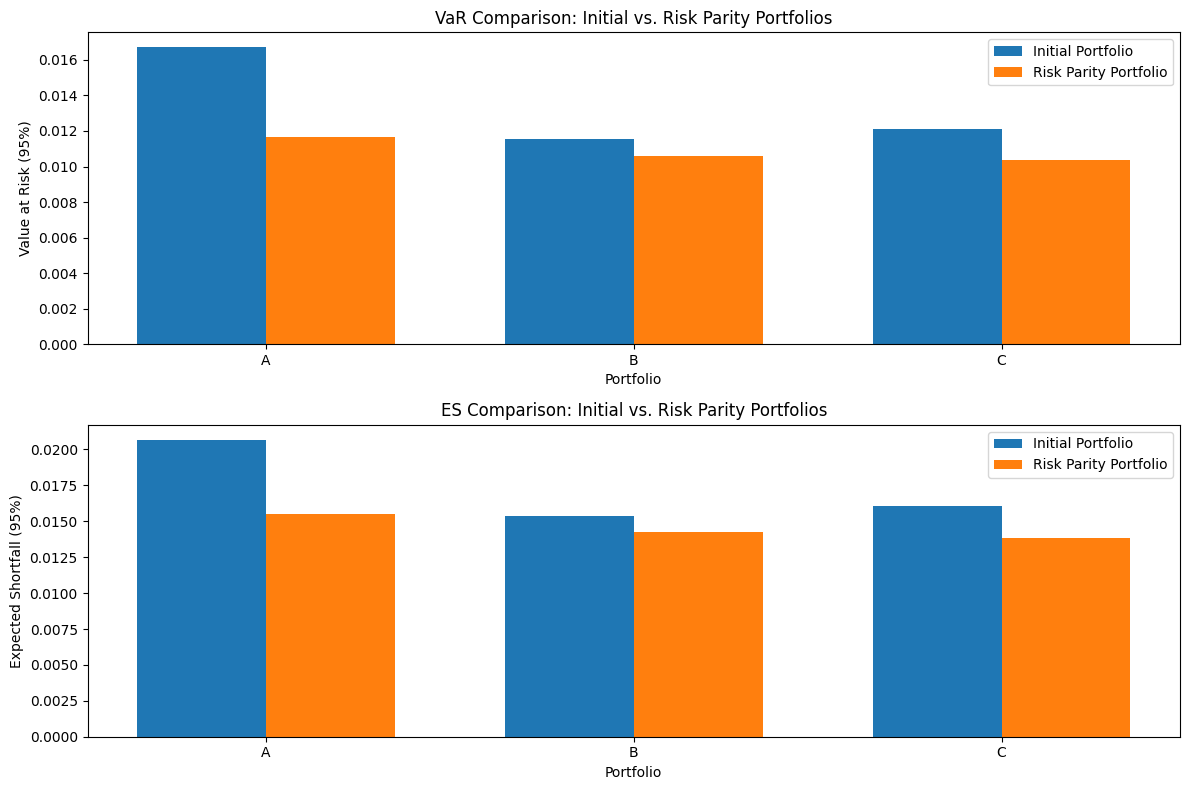

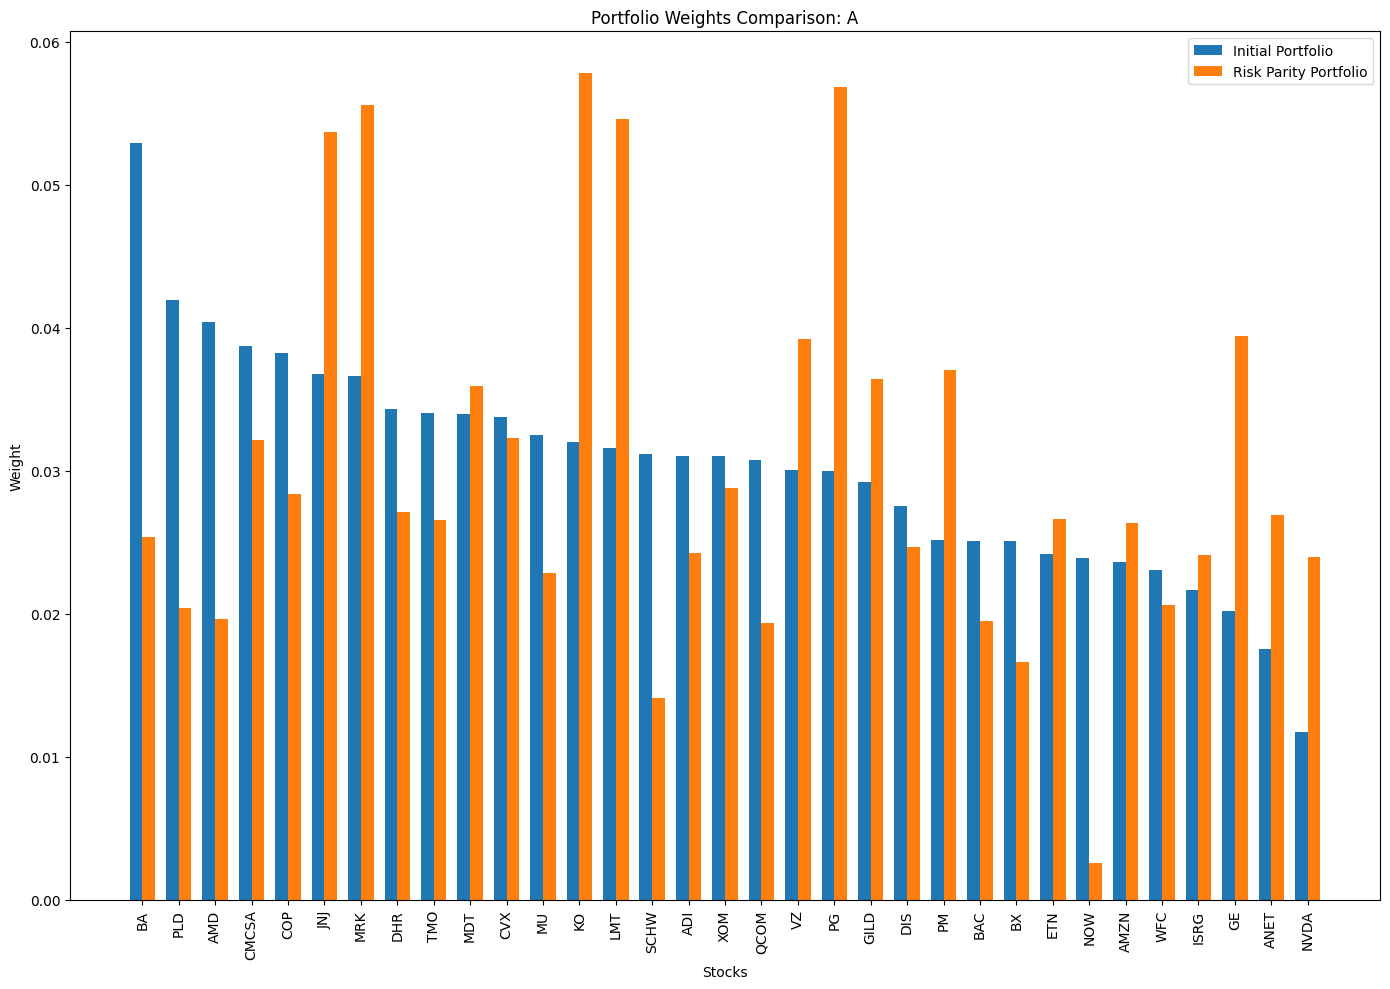

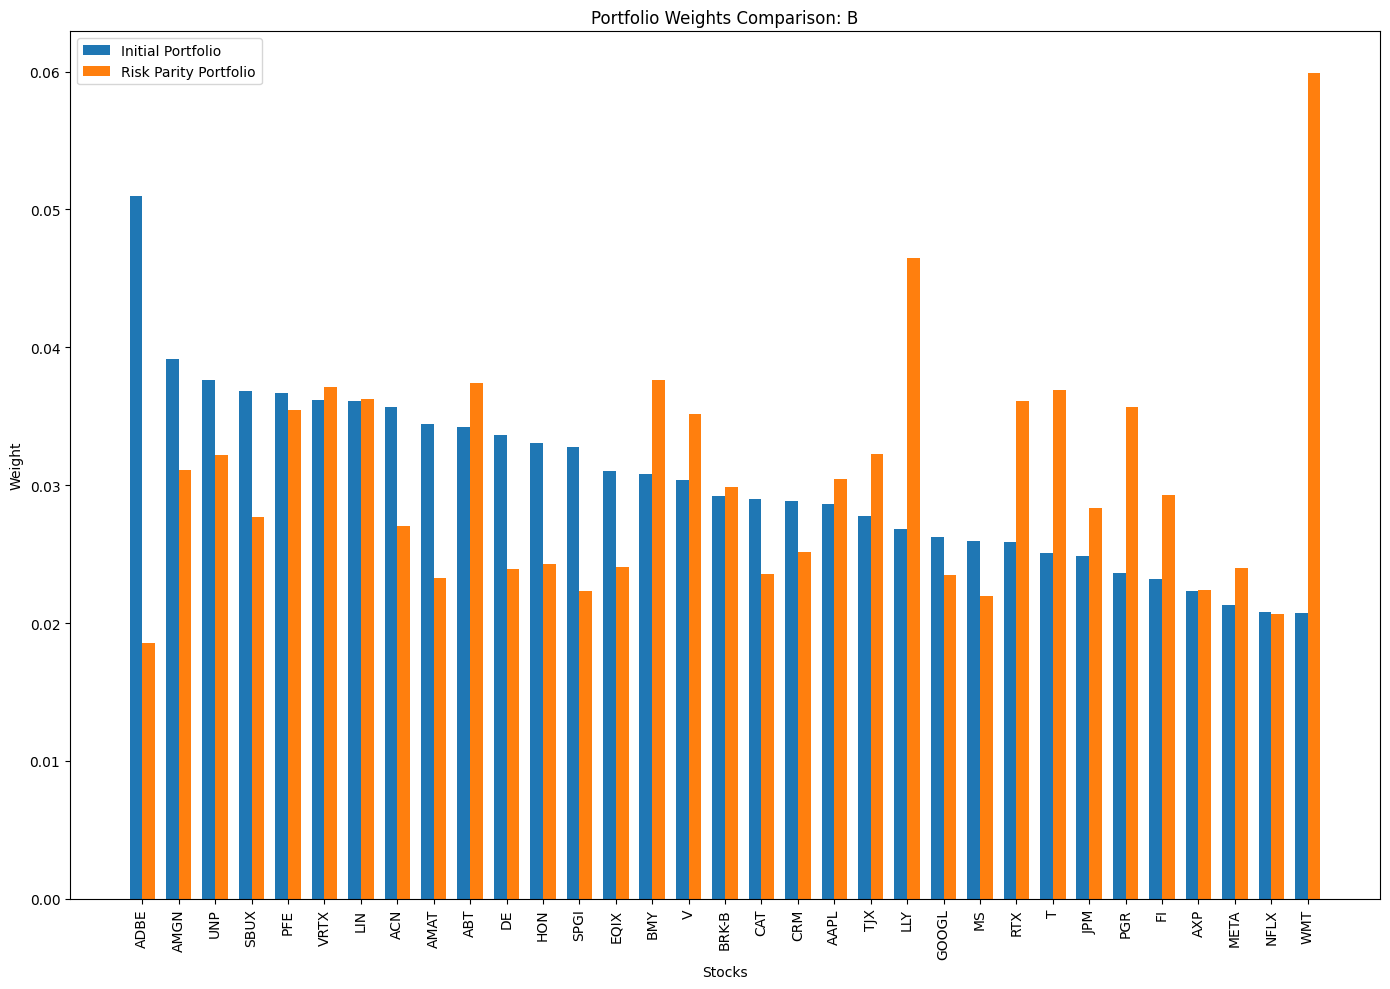

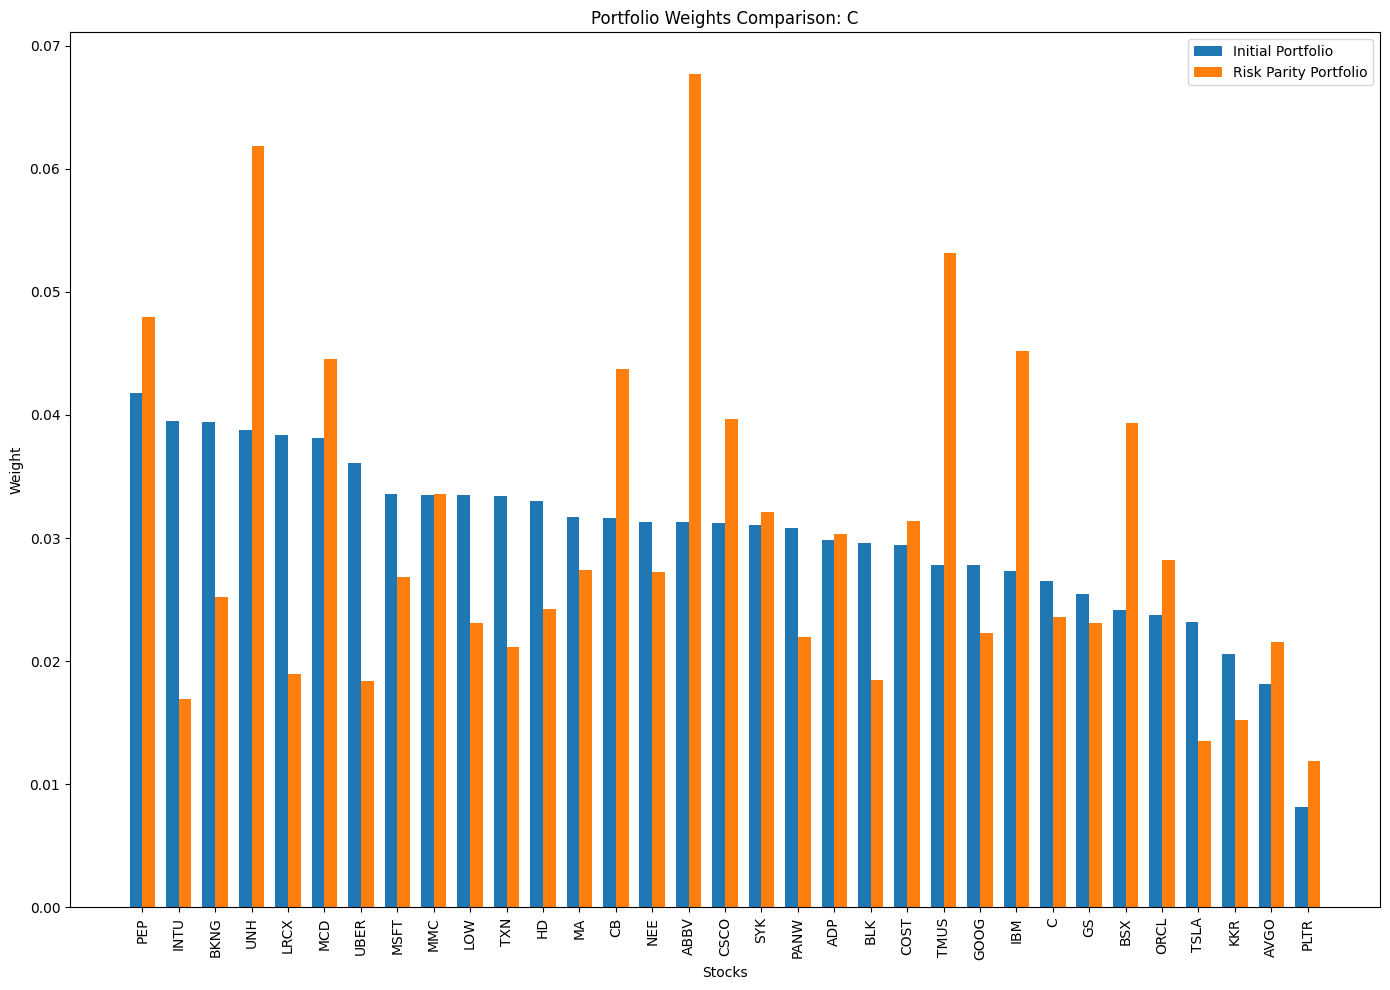

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, t
from scipy.optimize import minimize
import statsmodels.api as sm
from scipy.integrate import quad
import warnings
warnings.filterwarnings('ignore')

# For Normal Inverse Gaussian distribution
from scipy import special

# For Skew Normal distribution
from scipy.stats import skewnorm

def run_risk_parity_optimization():
    try:
        # 1. Load all required data files
        initial_portfolio = pd.read_csv('/Users/liruiqi/Desktop/545hw/Final_Project/initial_portfolio.csv')
        rf_data = pd.read_csv('/Users/liruiqi/Desktop/545hw/Final_Project/rf.csv')
        daily_prices = pd.read_csv('/Users/liruiqi/Desktop/545hw/Final_Project/DailyPrices.csv')

        # 2. Data preprocessing
        # 2.1 Set date as index
        daily_prices['Date'] = pd.to_datetime(daily_prices['Date'])
        daily_prices.set_index('Date', inplace=True)

        rf_data['Date'] = pd.to_datetime(rf_data['Date'])
        rf_data.set_index('Date', inplace=True)

        # 2.2 Find the end of 2023
        end_of_2023 = daily_prices[daily_prices.index.year == 2023].index.max()

        # 2.3 Split into training and test sets
        train_prices = daily_prices[daily_prices.index <= end_of_2023]
        test_prices = daily_prices[daily_prices.index > end_of_2023]

        # 3. Calculate daily returns for the training set
        train_returns = train_prices.pct_change().dropna()

        # 4. Organize portfolios
        portfolios = {}
        for portfolio_name in initial_portfolio['Portfolio'].unique():
            portfolio_stocks = initial_portfolio[initial_portfolio['Portfolio'] == portfolio_name]
            portfolios[portfolio_name] = portfolio_stocks

        # Import the code from Part 4
        # 5. Implement distribution classes and fitting functions
        # 5.1 Normal Distribution (already available in scipy)
        def fit_normal(returns):
            mu, sigma = norm.fit(returns)
            return {
                'name': 'Normal',
                'params': {'mu': mu, 'sigma': sigma},
                'dist': norm(mu, sigma)
            }

        # 5.2 Generalized T Distribution
        def generalized_t_pdf(x, mu, sigma, nu, tau):
            """Probability density function of Generalized T distribution"""
            c = special.gamma((nu + 1) / 2) / (special.gamma(nu / 2) * np.sqrt(np.pi * nu) * sigma)
            z = (x - mu) / sigma
            return c * (1 + z**2 / nu)**(-0.5 * (nu + 1))

        def generalized_t_loglik(params, data):
            """Log likelihood for Generalized T distribution"""
            mu, sigma, nu = params
            if sigma <= 0 or nu <= 0:  # Constraints
                return np.inf

            # Calculate log likelihood
            c = special.gamma((nu + 1) / 2) / (special.gamma(nu / 2) * np.sqrt(np.pi * nu) * sigma)
            z = (data - mu) / sigma
            loglik = np.sum(np.log(c) - 0.5 * (nu + 1) * np.log(1 + z**2 / nu))

            return -loglik  # Return negative log-likelihood for minimization

        def fit_generalized_t(returns):
            # Initial parameter estimates (mu, sigma, nu)
            mu_init = np.mean(returns)
            sigma_init = np.std(returns)
            nu_init = 5.0  # Arbitrary starting point for degrees of freedom

            # Parameter bounds
            bounds = [
                (None, None),  # mu can be any real number
                (1e-6, None),  # sigma must be positive
                (2.1, 50.0)    # nu constraint (degrees of freedom)
            ]

            # Optimize to find MLE
            result = minimize(
                generalized_t_loglik,
                [mu_init, sigma_init, nu_init],
                args=(returns,),
                bounds=bounds,
                method='L-BFGS-B'
            )

            if not result.success:
                print(f"Warning: Generalized T fit did not converge: {result.message}")

            mu, sigma, nu = result.x

            # Create a "dist" attribute similar to scipy's distributions
            class GeneralizedTDist:
                def __init__(self, mu, sigma, nu):
                    self.mu = mu
                    self.sigma = sigma
                    self.nu = nu

                def pdf(self, x):
                    return generalized_t_pdf(x, self.mu, self.sigma, self.nu, None)

                def cdf(self, x):
                    # Numerical integration of PDF for CDF
                    result = np.zeros_like(x, dtype=float)
                    for i, val in enumerate(x):
                        result[i], _ = quad(generalized_t_pdf, -np.inf, val, args=(self.mu, self.sigma, self.nu, None))
                    return result

                def ppf(self, q):
                    # Approximation using inverse of Student's t scaled appropriately
                    # This is an approximation - for exact values would need numerical methods
                    t_ppf = stats.t.ppf(q, self.nu)
                    return self.mu + self.sigma * t_ppf

            return {
                'name': 'Generalized T',
                'params': {'mu': mu, 'sigma': sigma, 'nu': nu},
                'dist': GeneralizedTDist(mu, sigma, nu)
            }

        # 5.3 Normal Inverse Gaussian Distribution
        def nig_pdf(x, alpha, beta, mu, delta):
            """PDF of Normal Inverse Gaussian distribution"""
            gamma = np.sqrt(alpha**2 - beta**2)
            temp = delta * gamma
            return (alpha * delta * special.k1(alpha * np.sqrt(delta**2 + (x - mu)**2)) *
                   np.exp(delta * gamma + beta * (x - mu)) /
                   (np.pi * np.sqrt(delta**2 + (x - mu)**2)))

        def nig_loglik(params, data):
            """Log likelihood for NIG distribution"""
            alpha, beta, mu, delta = params

            # Check constraints
            if delta <= 0 or alpha <= 0 or alpha <= abs(beta):
                return np.inf

            gamma = np.sqrt(alpha**2 - beta**2)
            n = len(data)

            loglik = n * np.log(alpha * delta / np.pi)
            loglik += n * delta * gamma

            for x in data:
                arg = alpha * np.sqrt(delta**2 + (x - mu)**2)
                loglik += np.log(special.k1(arg))
                loglik -= 0.5 * np.log(delta**2 + (x - mu)**2)
                loglik += beta * (x - mu)

            return -loglik  # Return negative log-likelihood for minimization

        def fit_nig(returns, max_tries=3):
            # Initial parameter estimates
            mu_init = np.mean(returns)
            sigma_init = np.std(returns)
            skew = stats.skew(returns)

            # Heuristic initial values based on moments
            delta_init = sigma_init
            alpha_init = 1.0 / sigma_init
            beta_init = skew * 0.1  # Small value based on skewness direction

            # Parameter bounds
            bounds = [
                (1e-6, 100),    # alpha > 0
                (-10, 10),      # beta (skewness parameter)
                (None, None),   # mu can be any real number
                (1e-6, 10)      # delta > 0
            ]

            best_result = None
            best_loglik = np.inf

            # Try multiple starting points if needed
            for _ in range(max_tries):
                try:
                    result = minimize(
                        nig_loglik,
                        [alpha_init, beta_init, mu_init, delta_init],
                        args=(returns,),
                        bounds=bounds,
                        method='L-BFGS-B'
                    )

                    if result.fun < best_loglik:
                        best_result = result
                        best_loglik = result.fun

                    # Slightly perturb initial values for next try
                    alpha_init *= np.random.uniform(0.8, 1.2)
                    beta_init *= np.random.uniform(0.8, 1.2)
                    delta_init *= np.random.uniform(0.8, 1.2)

                except Exception as e:
                    print(f"NIG fitting attempt failed: {e}")
                    continue

            if best_result is None:
                print("Warning: NIG fit failed for all attempts")
                return fit_normal(returns)  # fallback

            alpha, beta, mu, delta = best_result.x

            # Create a "dist" attribute similar to scipy's distributions
            class NIGDist:
                def __init__(self, alpha, beta, mu, delta):
                    self.alpha = alpha
                    self.beta = beta
                    self.mu = mu
                    self.delta = delta

                def pdf(self, x):
                    return nig_pdf(x, self.alpha, self.beta, self.mu, self.delta)

                def cdf(self, x):
                    # Numerical integration of PDF for CDF
                    result = np.zeros_like(x, dtype=float)
                    for i, val in enumerate(x):
                        result[i], _ = quad(nig_pdf, -np.inf, val,
                                           args=(self.alpha, self.beta, self.mu, self.delta))
                    return result

                def ppf(self, q):
                    # Approximate using numerical methods
                    # For simplicity, we can use a bisection method
                    def objective(x, q):
                        cdf_val, _ = quad(nig_pdf, -np.inf, x,
                                         args=(self.alpha, self.beta, self.mu, self.delta))
                        return cdf_val - q

                    result = np.zeros_like(q, dtype=float)
                    for i, qi in enumerate(q):
                        # Find suitable bounds
                        lower = self.mu - 10 * self.delta
                        upper = self.mu + 10 * self.delta

                        # Use bisection method for root finding
                        for _ in range(20):  # 20 iterations should be enough for reasonable precision
                            mid = (lower + upper) / 2
                            if objective(mid, qi) < 0:
                                lower = mid
                            else:
                                upper = mid

                        result[i] = mid

                    return result

            return {
                'name': 'Normal Inverse Gaussian',
                'params': {'alpha': alpha, 'beta': beta, 'mu': mu, 'delta': delta},
                'dist': NIGDist(alpha, beta, mu, delta),
                'loglik': -best_result.fun
            }

        # 5.4 Skew Normal Distribution
        def fit_skew_normal(returns):
            # Use scipy's skewnorm
            # a = shape parameter (skewness), loc = location, scale = scale
            a, loc, scale = skewnorm.fit(returns)

            return {
                'name': 'Skew Normal',
                'params': {'a': a, 'loc': loc, 'scale': scale},
                'dist': skewnorm(a, loc, scale)
            }

        # 6. Function to determine best fit using AIC
        def get_best_fit(returns):
            # List to store fit results and AIC values
            models = []

            # Fit each distribution
            try:
                normal_fit = fit_normal(returns)
                normal_loglik = np.sum(np.log(normal_fit['dist'].pdf(returns)))
                normal_aic = -2 * normal_loglik + 2 * 2  # 2 parameters: mu, sigma
                models.append((normal_fit, normal_aic))
            except Exception as e:
                print(f"Normal fitting error: {e}")

            try:
                gt_fit = fit_generalized_t(returns)
                # Calculate log-likelihood for Gen-T
                mu, sigma, nu = gt_fit['params'].values()
                z = (returns - mu) / sigma
                c = special.gamma((nu + 1) / 2) / (special.gamma(nu / 2) * np.sqrt(np.pi * nu) * sigma)
                gt_loglik = np.sum(np.log(c) - 0.5 * (nu + 1) * np.log(1 + z**2 / nu))
                gt_aic = -2 * gt_loglik + 2 * 3  # 3 parameters: mu, sigma, nu
                models.append((gt_fit, gt_aic))
            except Exception as e:
                print(f"Generalized T fitting error: {e}")

            try:
                nig_fit = fit_nig(returns)
                # For NIG, use the log-likelihood directly if stored, otherwise recompute
                params = list(nig_fit['params'].values())
                nig_loglik_val = nig_fit.get('loglik', -nig_loglik(params, returns))
                nig_aic = -2 * nig_loglik_val + 2 * 4  # 4 parameters: alpha, beta, mu, delta
                models.append((nig_fit, nig_aic))
            except Exception as e:
                print(f"NIG fitting error: {e}")

            try:
                skewnorm_fit = fit_skew_normal(returns)
                skewnorm_loglik = np.sum(np.log(skewnorm_fit['dist'].pdf(returns)))
                skewnorm_aic = -2 * skewnorm_loglik + 2 * 3  # 3 parameters: a, loc, scale
                models.append((skewnorm_fit, skewnorm_aic))
            except Exception as e:
                print(f"Skew Normal fitting error: {e}")

            # Find model with lowest AIC
            if not models:
                print("No models were successfully fit")
                return fit_normal(returns)  # Fallback to normal if all else fails

            best_model, best_aic = min(models, key=lambda x: x[1])
            return best_model

        # 7. Fit distributions to each stock's returns
        print("Fitting distributions to each stock's returns...")
        stock_fits = {}

        # Get list of all stocks from portfolios
        all_stocks = []
        for portfolio in portfolios.values():
            all_stocks.extend(portfolio['Symbol'].tolist())
        all_stocks = list(set(all_stocks))  # Remove duplicates

        # Fit distributions to each stock's returns
        for symbol in all_stocks:
            if symbol in train_returns.columns:
                print(f"Fitting distributions for {symbol}...")
                stock_returns = train_returns[symbol].dropna()
                if len(stock_returns) > 0:
                    stock_fits[symbol] = get_best_fit(stock_returns)
                    print(f"  Best fit for {symbol}: {stock_fits[symbol]['name']}")

        # 8. Simulate using Gaussian copula with fitted marginals
        def simulate_gaussian_copula(n_simulations, stock_fits, correlation_matrix, stocks):
            """
            Simulate returns using Gaussian copula with fitted marginal distributions

            Parameters:
            - n_simulations: Number of simulations
            - stock_fits: Dictionary of fitted distributions for each stock
            - correlation_matrix: Correlation matrix of returns
            - stocks: List of stock symbols to simulate

            Returns:
            - Dataframe of simulated returns
            """
            # 1. Generate correlated standard normal variables
            n_stocks = len(stocks)
            Z = np.random.multivariate_normal(
                mean=np.zeros(n_stocks),
                cov=correlation_matrix.values,
                size=n_simulations
            )

            # 2. Convert to uniform using normal CDF
            U = norm.cdf(Z)

            # 3. Convert to returns using fitted distributions' inverse CDF (ppf)
            simulated_returns = np.zeros_like(U)

            for i, stock in enumerate(stocks):
                if stock in stock_fits:
                    # Use the PPF (inverse CDF) of the fitted distribution
                    dist = stock_fits[stock]['dist']
                    simulated_returns[:, i] = dist.ppf(U[:, i])
                else:
                    # Fallback to normal distribution if fit not available
                    mu = np.mean(train_returns[stock].dropna())
                    sigma = np.std(train_returns[stock].dropna())
                    simulated_returns[:, i] = norm.ppf(U[:, i], loc=mu, scale=sigma)

            return pd.DataFrame(simulated_returns, columns=stocks)

        # 9. Calculate VaR and ES for a portfolio
        def calculate_var_es(returns, alpha=0.05):
            """Calculate Value at Risk and Expected Shortfall"""
            sorted_returns = np.sort(returns)
            var_idx = int(alpha * len(sorted_returns))
            var = -sorted_returns[var_idx]
            es = -sorted_returns[:var_idx].mean()
            return var, es

        # 10. Risk Parity Portfolio Optimization
        def risk_contribution(weights, cov_matrix):
            """
            Calculate the risk contribution of each asset in a portfolio

            Parameters:
            - weights: Portfolio weights
            - cov_matrix: Covariance matrix of returns

            Returns:
            - Array of risk contributions
            """
            port_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
            port_volatility = np.sqrt(port_variance)

            # Marginal contribution to risk
            marginal_contrib = np.dot(cov_matrix, weights)

            # Risk contribution
            risk_contrib = np.multiply(marginal_contrib, weights) / port_volatility

            return risk_contrib

        def es_risk_parity_objective(weights, sim_returns, alpha=0.05):
            """
            Objective function for risk parity portfolio using ES as risk metric

            Parameters:
            - weights: Portfolio weights
            - sim_returns: Simulated returns for all assets
            - alpha: Confidence level for ES

            Returns:
            - Objective value to minimize (sum of squared deviations from equal risk contribution)
            """
            # Calculate portfolio returns
            portfolio_returns = np.dot(sim_returns, weights)

            # Calculate ES for each asset's contribution
            sorted_returns = np.sort(portfolio_returns)
            var_idx = int(alpha * len(sorted_returns))
            tail_returns = sorted_returns[:var_idx]

            # Calculate marginal ES contribution for each asset
            marginal_es_contrib = np.zeros(len(weights))

            for i in range(len(weights)):
                asset_contrib = sim_returns[:, i] * weights[i]
                # Find ES contribution using tail events
                tail_indices = np.argsort(portfolio_returns)[:var_idx]
                marginal_es_contrib[i] = -np.mean(asset_contrib[tail_indices])

            # Total ES
            portfolio_es = -np.mean(tail_returns)

            # Risk contribution (percentage)
            risk_contrib = marginal_es_contrib / portfolio_es if portfolio_es > 0 else np.ones(len(weights)) / len(weights)

            # Target: equal risk contribution
            target_risk = 1.0 / len(weights)

            # Sum of squared deviations from target
            objective = np.sum((risk_contrib - target_risk)**2)

            return objective

        def optimize_es_risk_parity(symbols, sim_returns, n_attempts=5):
            """
            Optimize portfolio weights to achieve risk parity using ES

            Parameters:
            - symbols: List of stock symbols
            - sim_returns: Simulated returns DataFrame
            - n_attempts: Number of optimization attempts with different starting points

            Returns:
            - Optimal weights
            """
            n_assets = len(symbols)

            best_result = None
            best_objective = np.inf

            for _ in range(n_attempts):
                # Random starting weights
                initial_weights = np.random.random(n_assets)
                initial_weights /= initial_weights.sum()  # Normalize

                # Constraints: weights sum to 1 and all weights are positive
                constraints = [
                    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}  # Sum to 1
                ]

                bounds = tuple((0, 1) for _ in range(n_assets))  # All weights between 0 and 1

                # Optimize
                result = minimize(
                    es_risk_parity_objective,
                    initial_weights,
                    args=(sim_returns[symbols].values, 0.05),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=constraints,
                    options={'maxiter': 1000}
                )

                if result.success and result.fun < best_objective:
                    best_result = result
                    best_objective = result.fun

            if best_result is None:
                print("Warning: Risk parity optimization failed for all attempts")
                # Return equal weights as fallback
                return np.ones(n_assets) / n_assets

            optimal_weights = best_result.x

            # Ensure weights sum to 1 (handle small numerical errors)
            optimal_weights /= optimal_weights.sum()

            return optimal_weights

        # 11. CAPM Beta calculation
        def calculate_capm_beta(returns, market_returns):
            """
            Calculate CAPM beta for a set of returns

            Parameters:
            - returns: Asset returns
            - market_returns: Market returns

            Returns:
            - Beta value
            """
            # Clean data (remove NaN)
            clean_data = pd.concat([returns, market_returns], axis=1).dropna()

            if len(clean_data) == 0:
                return np.nan

            x = clean_data.iloc[:, 1].values  # Market returns
            y = clean_data.iloc[:, 0].values  # Asset returns

            # Add constant for regression
            X = sm.add_constant(x)

            # Fit regression model
            model = sm.OLS(y, X).fit()

            # Beta is the slope
            beta = model.params[1]

            return beta

        # 12. Performance Attribution
        def calculate_performance_attribution(portfolio_weights, returns, market_returns, rf_rate):
            """
            Calculate performance attribution based on CAPM

            Parameters:
            - portfolio_weights: Dictionary mapping symbols to weights
            - returns: DataFrame of asset returns
            - market_returns: Series of market returns
            - rf_rate: Risk-free rate

            Returns:
            - Dictionary with attribution results
            """
            # Create empty lists to store results
            symbols = []
            weights = []
            asset_returns = []
            betas = []

            # Process each asset
            for symbol, weight in portfolio_weights.items():
                if symbol in returns.columns:
                    symbols.append(symbol)
                    weights.append(weight)

                    # Calculate average return
                    asset_return = returns[symbol].mean()
                    asset_returns.append(asset_return)

                    # Calculate beta
                    beta = calculate_capm_beta(returns[symbol], market_returns)
                    betas.append(beta)

            # Convert to arrays
            weights = np.array(weights)
            asset_returns = np.array(asset_returns)
            betas = np.array(betas)

            # Normalize weights to sum to 1
            if weights.sum() > 0:
                weights = weights / weights.sum()

            # Calculate portfolio metrics
            port_return = np.sum(weights * asset_returns)
            port_beta = np.sum(weights * betas)

            # Market metrics
            market_return = market_returns.mean()
            risk_premium = market_return - rf_rate

            # Attribution
            beta_contribution = port_beta * risk_premium
            alpha_contribution = port_return - (rf_rate + beta_contribution)

            # Asset-level attribution
            asset_attribution = pd.DataFrame({
                'Symbol': symbols,
                'Weight': weights,
                'Return': asset_returns,
                'Beta': betas,
                'Beta_Contribution': betas * risk_premium * weights,
                'Alpha_Contribution': (asset_returns - (rf_rate + betas * risk_premium)) * weights
            })

            # Portfolio-level attribution
            portfolio_attribution = {
                'Portfolio_Return': port_return,
                'Risk_Free_Rate': rf_rate,
                'Risk_Premium': risk_premium,
                'Portfolio_Beta': port_beta,
                'Beta_Contribution': beta_contribution,
                'Alpha_Contribution': alpha_contribution
            }

            return {
                'Asset_Attribution': asset_attribution,
                'Portfolio_Attribution': portfolio_attribution
            }

        # 13. Main function execution
        # Set parameters
        alpha = 0.05  # 95% confidence level
        n_simulations = 10000

        # Calculate correlation matrix from returns
        correlation_matrix = train_returns.corr()

        # Create a dictionary to store risk parity weights
        risk_parity_weights = {}

        # Create a dictionary to store performance attribution results
        attribution_results = {}

        # Define market proxy (e.g., SPY) and calculate market returns
        # For this example, let's assume SPY is the market proxy
        market_proxy = 'SPY'  # Replace with the actual market proxy in your data

        # Make sure market_proxy exists in the data
        if market_proxy not in train_returns.columns:
            print(f"Warning: Market proxy {market_proxy} not found in data. Using equal-weighted portfolio as market proxy.")
            market_returns = train_returns.mean(axis=1)
        else:
            market_returns = train_returns[market_proxy]

        # Calculate average risk-free rate
        # Check the column name in rf_data
        if 'Rate' in rf_data.columns:
            rate_column = 'Rate'
        elif 'rate' in rf_data.columns:
            rate_column = 'rate'
        else:
            # If neither exists, print the available columns and use a default value
            print(f"Warning: 'Rate' column not found in rf_data. Available columns: {rf_data.columns.tolist()}")
            print("Using default risk-free rate of 0.02/252")
            avg_rf_rate = 0.02 / 252  # Default daily rate (2% annual)
            rate_column = None

        # Calculate the average rate if column was found
        if rate_column:
            avg_rf_rate = rf_data[rate_column].mean() / 252  # Daily rate

        print("\nCalculating Risk Parity Portfolios...")

        # Process each portfolio
        for portfolio_name in portfolios.keys():
            print(f"\nOptimizing portfolio {portfolio_name}...")

            portfolio_stocks = portfolios[portfolio_name]['Symbol'].tolist()
            valid_symbols = [s for s in portfolio_stocks if s in train_returns.columns]

            if not valid_symbols:
                print(f"No valid symbols for portfolio {portfolio_name}")
                continue

            # Simulate returns using Gaussian copula
            sim_returns = simulate_gaussian_copula(
                n_simulations,
                stock_fits,
                correlation_matrix.loc[valid_symbols, valid_symbols],
                valid_symbols
            )

            # Optimize risk parity weights
            optimal_weights = optimize_es_risk_parity(valid_symbols, sim_returns)

            # Store results as dictionary mapping symbols to weights
            weights_dict = dict(zip(valid_symbols, optimal_weights))
            risk_parity_weights[portfolio_name] = weights_dict

            # Print optimal weights
            print(f"Risk Parity Weights for {portfolio_name}:")
            for symbol, weight in weights_dict.items():
                print(f"  {symbol}: {weight:.4f}")

            # Calculate performance attribution
            attribution = calculate_performance_attribution(
                weights_dict,
                train_returns,
                market_returns,
                avg_rf_rate
            )

            attribution_results[portfolio_name] = attribution

        # Calculate for the total portfolio
        print("\nOptimizing Total Portfolio...")

        # Combine all unique stocks from all portfolios
        all_unique_stocks = []
        for weights in risk_parity_weights.values():
            all_unique_stocks.extend(weights.keys())
        all_unique_stocks = list(set(all_unique_stocks))

        # Simulate returns for all stocks
        valid_symbols = [s for s in all_unique_stocks if s in train_returns.columns]
        sim_returns_total = simulate_gaussian_copula(
            n_simulations,
            stock_fits,
            correlation_matrix.loc[valid_symbols, valid_symbols],
            valid_symbols
        )

        # Optimize risk parity weights for the total portfolio
        total_optimal_weights = optimize_es_risk_parity(valid_symbols, sim_returns_total)
        total_weights_dict = dict(zip(valid_symbols, total_optimal_weights))
        risk_parity_weights['Total'] = total_weights_dict

        # Print optimal weights for the total portfolio
        print(f"Risk Parity Weights for Total Portfolio:")
        for symbol, weight in total_weights_dict.items():
            print(f"  {symbol}: {weight:.4f}")

        # Calculate performance attribution for the total portfolio
        total_attribution = calculate_performance_attribution(
            total_weights_dict,
            train_returns,
            market_returns,
            avg_rf_rate
        )

        attribution_results['Total'] = total_attribution

        # 14. Performance summary
        print("\n=== Performance Attribution Summary ===")

        for portfolio_name, attribution in attribution_results.items():
            portfolio_attr = attribution['Portfolio_Attribution']

            print(f"\n{portfolio_name} Portfolio:")
            print(f"Return: {portfolio_attr['Portfolio_Return']*100:.4f}%")
            print(f"Beta: {portfolio_attr['Portfolio_Beta']:.4f}")
            print(f"Beta Contribution: {portfolio_attr['Beta_Contribution']*100:.4f}%")
            print(f"Alpha Contribution: {portfolio_attr['Alpha_Contribution']*100:.4f}%")

            # Top 5 contributors
            asset_attr = attribution['Asset_Attribution']
            asset_attr['Total_Contribution'] = asset_attr['Beta_Contribution'] + asset_attr['Alpha_Contribution']
            top_contributors = asset_attr.sort_values('Total_Contribution', ascending=False).head(5)

            print("\nTop 5 Contributors:")
            for _, row in top_contributors.iterrows():
                print(f"  {row['Symbol']}: {row['Total_Contribution']*100:.4f}% (Beta: {row['Beta_Contribution']*100:.4f}%, Alpha: {row['Alpha_Contribution']*100:.4f}%)")

        # 15. Calculate and report risk metrics for the optimized portfolios
        print("\n=== Risk Metrics for Optimized Portfolios ===")

        risk_metrics = {'Portfolio': [], 'VaR_Copula': [], 'ES_Copula': []}

        # Calculate risk metrics for each optimized portfolio
        for portfolio_name, weights_dict in risk_parity_weights.items():
            print(f"\nCalculating risk metrics for {portfolio_name}...")

            # Get portfolio stocks and weights
            symbols = list(weights_dict.keys())
            weights = list(weights_dict.values())

            # Simulate returns using Gaussian copula
            sim_returns = simulate_gaussian_copula(
                n_simulations,
                stock_fits,
                correlation_matrix.loc[symbols, symbols],
                symbols
            )

            # Calculate portfolio returns
            portfolio_returns = np.zeros(n_simulations)
            for i, symbol in enumerate(symbols):
                portfolio_returns += weights[i] * sim_returns[symbol].values

            # Calculate VaR and ES
            var_copula, es_copula = calculate_var_es(portfolio_returns, alpha)

            # Store results
            risk_metrics['Portfolio'].append(portfolio_name)
            risk_metrics['VaR_Copula'].append(var_copula)
            risk_metrics['ES_Copula'].append(es_copula)

            print(f"  VaR (95%): {var_copula:.4f}")
            print(f"  ES (95%): {es_copula:.4f}")

        # Convert results to dataframe
        risk_metrics_df = pd.DataFrame(risk_metrics)

        print("\n=== Risk Metrics Summary ===")
        print(risk_metrics_df)

        # 16. Compare with initial portfolio risk metrics
        print("\n=== Comparison with Initial vs. Risk Parity Portfolios ===")

        # Calculate risk metrics for initial portfolios
        initial_risk_metrics = {'Portfolio': [], 'VaR_Initial': [], 'ES_Initial': []}

        for portfolio_name, portfolio_df in portfolios.items():
            print(f"\nCalculating risk metrics for initial {portfolio_name}...")

            # Calculate initial weights based on holdings and prices at end_of_2023
            end_of_2023_prices = daily_prices.loc[end_of_2023]

            initial_values = {}
            for _, row in portfolio_df.iterrows():
                symbol = row['Symbol']
                holding = row['Holding']

                if symbol in end_of_2023_prices and not np.isnan(end_of_2023_prices[symbol]):
                    initial_values[symbol] = holding * end_of_2023_prices[symbol]

            total_value = sum(initial_values.values())
            initial_weights = {symbol: value / total_value for symbol, value in initial_values.items()}

            # Get valid symbols with data
            valid_symbols = [s for s in initial_weights.keys() if s in train_returns.columns]

            # Adjust weights to sum to 1 for valid symbols only
            valid_weights_sum = sum(initial_weights[s] for s in valid_symbols)
            weights = [initial_weights[s] / valid_weights_sum for s in valid_symbols]

            # Simulate returns
            sim_returns = simulate_gaussian_copula(
                n_simulations,
                stock_fits,
                correlation_matrix.loc[valid_symbols, valid_symbols],
                valid_symbols
            )

            # Calculate portfolio returns
            portfolio_returns = np.zeros(n_simulations)
            for i, symbol in enumerate(valid_symbols):
                portfolio_returns += weights[i] * sim_returns[symbol].values

            # Calculate VaR and ES
            var_initial, es_initial = calculate_var_es(portfolio_returns, alpha)

            # Store results
            initial_risk_metrics['Portfolio'].append(portfolio_name)
            initial_risk_metrics['VaR_Initial'].append(var_initial)
            initial_risk_metrics['ES_Initial'].append(es_initial)

            print(f"  VaR (95%): {var_initial:.4f}")
            print(f"  ES (95%): {es_initial:.4f}")

        # Convert results to dataframe
        initial_risk_metrics_df = pd.DataFrame(initial_risk_metrics)

        # Merge results for comparison
        comparison_df = pd.merge(initial_risk_metrics_df, risk_metrics_df, on='Portfolio')
        comparison_df['VaR_Improvement'] = (comparison_df['VaR_Initial'] - comparison_df['VaR_Copula']) / comparison_df['VaR_Initial'] * 100
        comparison_df['ES_Improvement'] = (comparison_df['ES_Initial'] - comparison_df['ES_Copula']) / comparison_df['ES_Initial'] * 100

        print("\n=== Risk Improvement Summary ===")
        print(comparison_df)

        # 17. Visualize the portfolios and risk metrics
        # Create plots for risk metrics comparison
        plt.figure(figsize=(12, 8))

        # VaR comparison
        plt.subplot(2, 1, 1)
        bar_width = 0.35
        indices = np.arange(len(comparison_df['Portfolio']))

        plt.bar(indices - bar_width/2, comparison_df['VaR_Initial'], bar_width, label='Initial Portfolio')
        plt.bar(indices + bar_width/2, comparison_df['VaR_Copula'], bar_width, label='Risk Parity Portfolio')

        plt.xlabel('Portfolio')
        plt.ylabel('Value at Risk (95%)')
        plt.title('VaR Comparison: Initial vs. Risk Parity Portfolios')
        plt.xticks(indices, comparison_df['Portfolio'])
        plt.legend()

        # ES comparison
        plt.subplot(2, 1, 2)
        plt.bar(indices - bar_width/2, comparison_df['ES_Initial'], bar_width, label='Initial Portfolio')
        plt.bar(indices + bar_width/2, comparison_df['ES_Copula'], bar_width, label='Risk Parity Portfolio')

        plt.xlabel('Portfolio')
        plt.ylabel('Expected Shortfall (95%)')
        plt.title('ES Comparison: Initial vs. Risk Parity Portfolios')
        plt.xticks(indices, comparison_df['Portfolio'])
        plt.legend()

        plt.tight_layout()
        plt.savefig('risk_metrics_comparison.png')

        # Create plots for weights comparison (for each portfolio)
        for portfolio_name in risk_parity_weights.keys():
            if portfolio_name == 'Total':
                continue  # Skip the total portfolio for individual comparisons

            # Get initial weights
            initial_portfolio_df = portfolios[portfolio_name]
            end_of_2023_prices = daily_prices.loc[end_of_2023]

            initial_values = {}
            for _, row in initial_portfolio_df.iterrows():
                symbol = row['Symbol']
                holding = row['Holding']

                if symbol in end_of_2023_prices and not np.isnan(end_of_2023_prices[symbol]):
                    initial_values[symbol] = holding * end_of_2023_prices[symbol]

            total_value = sum(initial_values.values())
            initial_weights = {symbol: value / total_value for symbol, value in initial_values.items()}

            # Get risk parity weights
            rp_weights = risk_parity_weights[portfolio_name]

            # Create a unified set of symbols
            all_symbols = list(set(list(initial_weights.keys()) + list(rp_weights.keys())))

            # Prepare data for plotting
            initial_data = [initial_weights.get(symbol, 0) for symbol in all_symbols]
            rp_data = [rp_weights.get(symbol, 0) for symbol in all_symbols]

            # Sort by initial weight
            sorted_indices = np.argsort(initial_data)[::-1]
            sorted_symbols = [all_symbols[i] for i in sorted_indices]
            sorted_initial = [initial_data[i] for i in sorted_indices]
            sorted_rp = [rp_data[i] for i in sorted_indices]

            # Create plot
            plt.figure(figsize=(14, 10))
            indices = np.arange(len(sorted_symbols))

            plt.bar(indices - bar_width/2, sorted_initial, bar_width, label='Initial Portfolio')
            plt.bar(indices + bar_width/2, sorted_rp, bar_width, label='Risk Parity Portfolio')

            plt.xlabel('Stocks')
            plt.ylabel('Weight')
            plt.title(f'Portfolio Weights Comparison: {portfolio_name}')
            plt.xticks(indices, sorted_symbols, rotation=90)
            plt.legend()

            plt.tight_layout()
            plt.savefig(f'weights_comparison_{portfolio_name}.png')

        # 18. Return results for further analysis
        return {
            'stock_fits': stock_fits,
            'risk_parity_weights': risk_parity_weights,
            'attribution_results': attribution_results,
            'risk_metrics': risk_metrics_df,
            'initial_risk_metrics': initial_risk_metrics_df,
            'comparison': comparison_df
        }

    except Exception as e:
        print(f"Error in risk parity optimization: {e}")
        import traceback
        traceback.print_exc()
        return None

if __name__ == "__main__":
    results = run_risk_parity_optimization()

In [54]:
# Hardcoded portfolio performance data (daily values)
portfolio_data = {
    'Portfolio': ['A', 'B', 'C', 'Total'],
    'Daily_Return': [0.0813, 0.0905, 0.1018, 0.0909],
    'Beta': [0.8404, 0.8318, 0.8294, 0.8301],
    'Daily_Beta_Contribution': [0.0761, 0.0753, 0.0751, 0.0752],
    'Daily_Alpha_Contribution': [-0.0027, 0.0072, 0.0187, 0.0078]
}

# Risk metrics data
risk_metrics = {
    'Portfolio': ['A', 'B', 'C', 'Total'],
    'VaR_Initial': [0.016717, 0.011558, 0.012089, None],  # Total portfolio doesn't have an initial VaR
    'ES_Initial': [0.020681, 0.015352, 0.016035, None],
    'VaR_Copula': [0.011646, 0.010582, 0.010359, 0.010397],
    'ES_Copula': [0.015486, 0.014243, 0.013842, 0.013999],
    'VaR_Improvement': [30.332772, 8.437395, 14.311496, None],
    'ES_Improvement': [25.116913, 7.225107, 13.676761, None]
}

# Convert daily portfolio metrics to annual (multiply by 254)
annual_performance = {
    'Portfolio': portfolio_data['Portfolio'],
    'Annual_Return': [r * 254 for r in portfolio_data['Daily_Return']],
    'Beta': portfolio_data['Beta'],
    'Annual_Beta_Contribution': [bc * 254 for bc in portfolio_data['Daily_Beta_Contribution']],
    'Annual_Alpha_Contribution': [ac * 254 for ac in portfolio_data['Daily_Alpha_Contribution']]
}

# Create a nice formatted table for the annual portfolio performance
print("\n===== Annual Portfolio Performance =====")
print(f"{'Portfolio':<10} {'Annual Return':>15} {'Beta':>10} {'Beta Contrib':>15} {'Alpha Contrib':>15}")
print("="*65)

for i in range(len(annual_performance['Portfolio'])):
    print(f"{annual_performance['Portfolio'][i]:<10} {annual_performance['Annual_Return'][i]:>14.2f}% {annual_performance['Beta'][i]:>10.4f} {annual_performance['Annual_Beta_Contribution'][i]:>14.2f}% {annual_performance['Annual_Alpha_Contribution'][i]:>14.2f}%")



===== Annual Portfolio Performance =====
Portfolio    Annual Return       Beta    Beta Contrib   Alpha Contrib
A                   20.65%     0.8404          19.33%          -0.69%
B                   22.99%     0.8318          19.13%           1.83%
C                   25.86%     0.8294          19.08%           4.75%
Total               23.09%     0.8301          19.10%           1.98%
